# Exploring Cost_of_Living

## Import librery

In [68]:
import empiricaldist
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import scipy.stats
from sklearn.neighbors import KernelDensity
import missingno

## Graphics Appearance

In [69]:
%matplotlib inline
sns.set_style(rc={'axes.facecolor':'#dddede'}, style = 'darkgrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (9, 6)


continent_color = {
    'America': '#97DB4F',
    'Europe': '#0f7175ff',
    'Asia' :'#c65dc9ff',
    'Oceania':'#F9704E',
    'Africa': '#53d8fb'
}

# Data

## Load Data

In [70]:
df_cost_des = pd.read_csv('bestCountry/cost/cost-2023-mid.csv')

## Explain Data

These indices are relative to New York City (NYC). Which means that for New York City, each index should be 100(%). If another country has, for example, rent index of 120, it means that on an average in that country rents are 20% more expensive than in New York City. If a country has rent index of 70, that means on average rent in that country is 30% less expensive than in New York City.

* **Cost_of_Living Index (Excl. Rent):** is a relative indicator of consumer goods prices, including groceries, restaurants, transportation and utilities. Cost_of_Living Index does not include accommodation expenses such as rent or mortgage. If a country has a Cost_of_Living Index of 120, it means Numbeo has estimated it is 20% more expensive than New York (excluding rent).

* **Rent Index:** is an estimation of prices of renting apartments in the country compared to New York City. If Rent index is 80, Numbeo has estimated that price of rents in that country is on average 20% less than the price in New York.

* **Groceries Index:** is an estimation of grocery prices in the country compared to New York City. To calculate this section, Numbeo uses weights of items in the "Markets" section for each country.

* **Restaurants Index:** is a comparison of prices of meals and drinks in restaurants and bars compared to NYC.

* **Cost_of_Living Plus Rent Index:** is an estimation of consumer goods prices including rent comparing to New York City.

* **Local_Purchasing_Power:** shows relative purchasing power in buying goods and services in a given country for the average net salary in that country. If domestic purchasing power is 40, this means that the inhabitants of that country with an average salary can afford to buy on an average 60% less goods and services than New York City residents with an average salary.

## Normalize

How the data is relative to New York. So, we need to analize since a world means

In [71]:
means = df_cost_des.iloc[:, 1:-1].mean()

# Ajustar los datos restando la media mundial para cada columna numérica
df_cost = df_cost_des.copy()

for column in means.index:
    df_cost[column] = df_cost[column] - means[column]

# Mostrar el DataFrame con las nuevas columnas ajustadas

df_cost.head()


,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power
0,Bermuda,2.910865,4.967191,3.444773,3.268500,3.317892,75.9
1,Switzerland,2.419875,2.702579,2.494692,2.595707,2.629406,110.8
2,Cayman Islands,2.380679,4.267511,2.870644,2.382050,2.420275,71.4
3,Bahamas,1.933012,2.179155,1.996336,1.770627,2.201746,37.4
4,Iceland,1.809233,2.104380,1.885591,1.907004,2.194696,100.4


In [72]:
columns = df_cost.select_dtypes(include=np.number)

for column in columns:
    df_cost[column] = round(df_cost[column], 1)
    
df_cost

,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power
0,Bermuda,2.9,5.0,3.4,3.3,3.3,75.9
1,Switzerland,2.4,2.7,2.5,2.6,2.6,110.8
2,Cayman Islands,2.4,4.3,2.9,2.4,2.4,71.4
3,Bahamas,1.9,2.2,2.0,1.8,2.2,37.4
4,Iceland,1.8,2.1,1.9,1.9,2.2,100.4
...,...,...,...,...,...,...,...
135,Libya,0.5,0.3,0.4,0.5,0.5,31.6
136,Nigeria,0.5,0.9,0.6,0.6,0.4,9.4
137,India,0.5,0.3,0.4,0.5,0.4,61.7
138,Egypt,0.4,0.2,0.4,0.4,0.4,17.4


In [73]:
df_cost_des['Local_Purchasing_Power'].mean()

49.81928571428572

In [74]:
df_cost_des[df_cost_des['Country'] == 'Colombia']

,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power
128,Colombia,27.6,8.0,18.3,25.8,20.9,27.9


In [75]:
df_cost[df_cost['Country'] == 'Colombia']

,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power
128,Colombia,0.6,0.4,0.5,0.6,0.5,27.9


## Create a new Column

Create the column "continente" to separate by this

In [76]:
africa = ['Senegal', 'Ivory Coast', 'Ethiopia', 'Mauritius', 'Zimbabwe', 'South Africa', 'Namibia', 'Botswana', 'Cameroon', 'Kenya', 'Uganda', 'Nigeria', 'Tanzania', 'Rwanda', 'Morocco', 'Algeria', 'Ghana', 'Tunisia', 'Libya', 'Egypt']
america = ['Bermuda', 'Cayman Islands', 'Bahamas', 'Barbados', 'United States', 'Puerto Rico', 'Canada', 'Uruguay', 'Jamaica', 'Trinidad And Tobago', 'Cuba', 'Costa Rica', 'Panama', 'Belize', 'Guyana', 'Chile', 'El Salvador', 'Dominican Republic', 'Venezuela', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Ecuador', 'Brazil', 'Peru', 'Bolivia', 'Argentina', 'Paraguay', 'Colombia']
asia = ['Singapore', 'Israel', 'Hong Kong (China)', 'South Korea', 'Macao (China)', 'Lebanon', 'Japan', 'United Arab Emirates', 'Qatar', 'Yemen', 'Cyprus', 'Brunei', 'Maldives', 'Taiwan (China)', 'Bahrain', 'Palestine', 'Saudi Arabia', 'Oman', 'Kuwait', 'Jordan', 'Cambodia', 'Armenia', 'Thailand', 'China', 'Georgia', 'Vietnam', 'Iran', 'Malaysia', 'Philippines', 'Myanmar', 'Iraq', 'Mongolia', 'Indonesia', 'Azerbaijan', 'Kazakhstan', 'Turkey', 'Uzbekistan', 'Bangladesh', 'Syria', 'Kyrgyzstan', 'Sri Lanka', 'Nepal', 'India', 'Pakistan']
europe = ['Switzerland', 'Norway', 'Iceland', 'Jersey', 'Denmark', 'Luxembourg', 'Guernsey', 'Ireland', 'France', 'Netherlands', 'Finland', 'Austria', 'Belgium', 'Germany', 'Sweden', 'Isle Of Man', 'United Kingdom', 'Malta', 'Italy', 'Estonia', 'Greece', 'Latvia', 'Slovenia', 'Spain', 'Czech Republic', 'Lithuania', 'Croatia', 'Portugal', 'Slovakia', 'Russia', 'Bulgaria', 'Hungary', 'Montenegro', 'Poland', 'Albania', 'Romania', 'Serbia', 'Belarus', 'Bosnia And Herzegovina', 'Moldova', 'North Macedonia', 'Kosovo (Disputed Territory)', 'Ukraine']
oceania = ['Australia', 'New Zealand', 'Fiji']



africa_dict = dict.fromkeys(africa, 'Africa')
americ_dict = dict.fromkeys(america, 'America')
asia_dict = dict.fromkeys(asia, "Asia")
europe_dict = dict.fromkeys(europe, "Europe")
oceania_dict = dict.fromkeys(oceania, "Oceania")


dictionary = africa_dict | americ_dict | asia_dict | europe_dict | oceania_dict

df_cost['Continente'] = df_cost['Country'].map(dictionary)


# Data Validation

In [77]:
df_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 140 non-null    object 
 1   Cost_of_Living          140 non-null    float64
 2   Rent                    140 non-null    float64
 3   Cost_Plus_Rent          140 non-null    float64
 4   Groceries               140 non-null    float64
 5   Restaurant_Price        140 non-null    float64
 6   Local_Purchasing_Power  140 non-null    float64
 7   Continente              138 non-null    object 
dtypes: float64(6), object(2)
memory usage: 8.9+ KB


See what data type are are into dataset, in this case isn't convert some of this and theren't null values

In [78]:
df_cost.describe()

,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,1.000000,0.999286,1.000000,1.000000,1.000714,49.819286
std,0.414312,0.827973,0.503799,0.443336,0.556647,31.243511
min,0.400000,0.200000,0.300000,0.300000,0.300000,1.500000
25%,0.700000,0.500000,0.600000,0.700000,0.600000,27.750000
50%,0.900000,0.800000,0.900000,0.900000,0.850000,37.650000
75%,1.200000,1.200000,1.200000,1.200000,1.225000,71.925000
max,2.900000,5.000000,3.400000,3.300000,3.300000,156.800000


We can conclude that the data set is inclined to left. Remember that data is negative in this case.

In [79]:
df_cost.dtypes

Country                    object
Cost_of_Living            float64
Rent                      float64
Cost_Plus_Rent            float64
Groceries                 float64
Restaurant_Price          float64
Local_Purchasing_Power    float64
Continente                 object
dtype: object

In [80]:
(
    df_cost
    .dtypes
    .value_counts()
)

float64    6
object     2
dtype: int64

In [81]:
df_cost.shape

(140, 8)

# Count 

## Estadistics to describe dataset

In [82]:
df_cost.describe(include= 'all')

,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power,Continente
count,140,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,138
unique,140,NaN,NaN,NaN,NaN,NaN,NaN,5
top,Bermuda,NaN,NaN,NaN,NaN,NaN,NaN,Europe
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,43
mean,NaN,1.000000,0.999286,1.000000,1.000000,1.000714,49.819286,NaN
std,NaN,0.414312,0.827973,0.503799,0.443336,0.556647,31.243511,NaN
min,NaN,0.400000,0.200000,0.300000,0.300000,0.300000,1.500000,NaN
25%,NaN,0.700000,0.500000,0.600000,0.700000,0.600000,27.750000,NaN
50%,NaN,0.900000,0.800000,0.900000,0.900000,0.850000,37.650000,NaN
75%,NaN,1.200000,1.200000,1.200000,1.200000,1.225000,71.925000,NaN


### Only numerics

In [83]:
df_cost.describe(include= (np.number))

,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,1.000000,0.999286,1.000000,1.000000,1.000714,49.819286
std,0.414312,0.827973,0.503799,0.443336,0.556647,31.243511
min,0.400000,0.200000,0.300000,0.300000,0.300000,1.500000
25%,0.700000,0.500000,0.600000,0.700000,0.600000,27.750000
50%,0.900000,0.800000,0.900000,0.900000,0.850000,37.650000
75%,1.200000,1.200000,1.200000,1.200000,1.225000,71.925000
max,2.900000,5.000000,3.400000,3.300000,3.300000,156.800000


### Trend measures

#### Mean

In [84]:
df_cost.mean()

/tmp/ipykernel_940/46364248.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cost.mean()


Cost_of_Living             1.000000
Rent                       0.999286
Cost_Plus_Rent             1.000000
Groceries                  1.000000
Restaurant_Price           1.000714
Local_Purchasing_Power    49.819286
dtype: float64

> All average data is negative, that's mean data is skewed to the left

In [85]:
df_cost.median()

/tmp/ipykernel_940/179467506.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cost.median()


Cost_of_Living             0.90
Rent                       0.80
Cost_Plus_Rent             0.90
Groceries                  0.90
Restaurant_Price           0.85
Local_Purchasing_Power    37.65
dtype: float64

#### Mode

In [86]:
df_cost.mode(axis = 0, numeric_only= True, dropna = True)

,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power
0,0.6,0.5,0.6,0.8,0.7,28.0


## Dispersion measures

### Max values 

In [87]:
df_cost.max(numeric_only= True)

Cost_of_Living              2.9
Rent                        5.0
Cost_Plus_Rent              3.4
Groceries                   3.3
Restaurant_Price            3.3
Local_Purchasing_Power    156.8
dtype: float64

local_Purchasig_Power look that there are some country(s) that are best, pay any more than New York 

### Min values

In [88]:
df_cost.min(numeric_only= True)

Cost_of_Living            0.4
Rent                      0.2
Cost_Plus_Rent            0.3
Groceries                 0.3
Restaurant_Price          0.3
Local_Purchasing_Power    1.5
dtype: float64

But, can see that there're some country(s) poor too, talking Local Purchasing Power

### Standar desviation

In [89]:
df_cost.std()

/tmp/ipykernel_940/3839886180.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cost.std()


Cost_of_Living             0.414312
Rent                       0.827973
Cost_Plus_Rent             0.503799
Groceries                  0.443336
Restaurant_Price           0.556647
Local_Purchasing_Power    31.243511
dtype: float64

> Some variables has a low desviation standard, in this case biggest desviation is 'Local_Purchasing_Power'. Below show how is data distribution

In [90]:
cost_75 = df_cost.quantile(0.75)
cost_25 = df_cost.quantile(0.25)
print(f'Quantile 75:\n{cost_75} \n\n Quantile 25:\n {cost_25} \n\n Quantile 50: \n {cost_75 - cost_25}')

Quantile 75:
Cost_of_Living             1.200
Rent                       1.200
Cost_Plus_Rent             1.200
Groceries                  1.200
Restaurant_Price           1.225
Local_Purchasing_Power    71.925
Name: 0.75, dtype: float64 

 Quantile 25:
 Cost_of_Living             0.70
Rent                       0.50
Cost_Plus_Rent             0.60
Groceries                  0.70
Restaurant_Price           0.60
Local_Purchasing_Power    27.75
Name: 0.25, dtype: float64 

 Quantile 50: 
 Cost_of_Living             0.500
Rent                       0.700
Cost_Plus_Rent             0.600
Groceries                  0.500
Restaurant_Price           0.625
Local_Purchasing_Power    44.175
dtype: float64


/tmp/ipykernel_940/1285807883.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cost_75 = df_cost.quantile(0.75)
/tmp/ipykernel_940/1285807883.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cost_25 = df_cost.quantile(0.25)


In [91]:
(
    df_cost
    .quantile(q=[0.75, 0.5, 0.25])
    .T
    .rename_axis('variables')
    .reset_index()
    .assign(
        iqr = lambda df : df[0.75] - df[0.25]
    )
)

/tmp/ipykernel_940/517929729.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cost


,variables,0.75,0.5,0.25,iqr
0,Cost_of_Living,1.200,0.90,0.70,0.500
1,Rent,1.200,0.80,0.50,0.700
2,Cost_Plus_Rent,1.200,0.90,0.60,0.600
3,Groceries,1.200,0.90,0.70,0.500
4,Restaurant_Price,1.225,0.85,0.60,0.625
5,Local_Purchasing_Power,71.925,37.65,27.75,44.175


> Looking quantiles to all columns

# Distribution Visualization

## Histplot

In [92]:
cols = df_cost.select_dtypes(np.number).columns

Variable 'cols' refers to numeric columns only

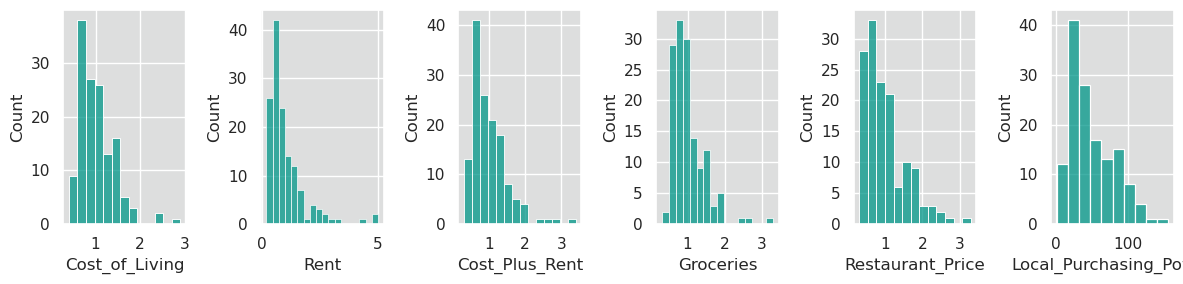

In [93]:
fig, ax = plt.subplots(1,6, figsize = (12,3))

for i, i_col in enumerate(cols):
    sns.histplot(
        ax = ax[i],
        data = df_cost,
        x = i_col,
        color = '#009688'
    )

plt.tight_layout()

> All variables are skewed to the left

## Boxplot

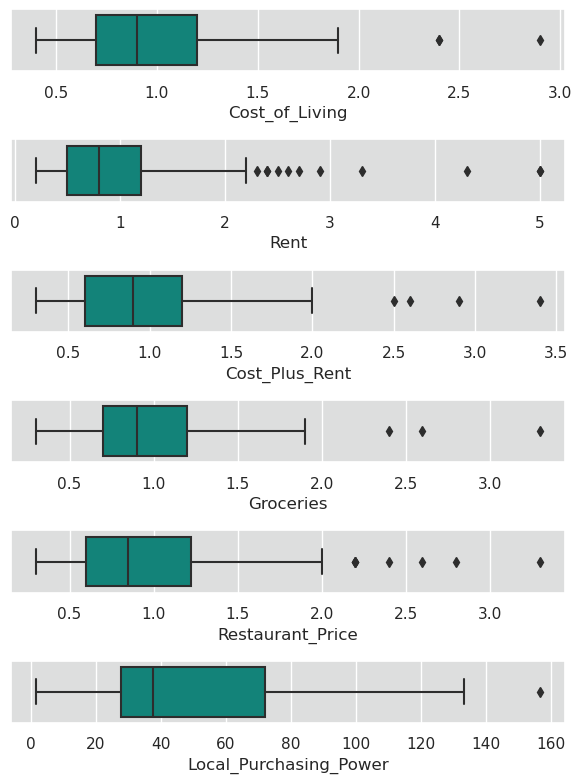

In [94]:
fig, ax = plt.subplots(6, figsize = (6,8))

for i, i_col in enumerate(cols):
    sns.boxplot(
        ax = ax[i],
        data = df_cost,
        x = i_col,
        color = '#009688'
    )

plt.tight_layout()

> There are a lot of outliers, it will be removed to a general analysis. But we need all data for a deep exploring

### Per Continent

In [95]:
df_cost.columns

Index(['Country', 'Cost_of_Living', 'Rent', 'Cost_Plus_Rent', 'Groceries',
       'Restaurant_Price', 'Local_Purchasing_Power', 'Continente'],
      dtype='object')

<Axes: xlabel='Cost_of_Living', ylabel='Continente'>

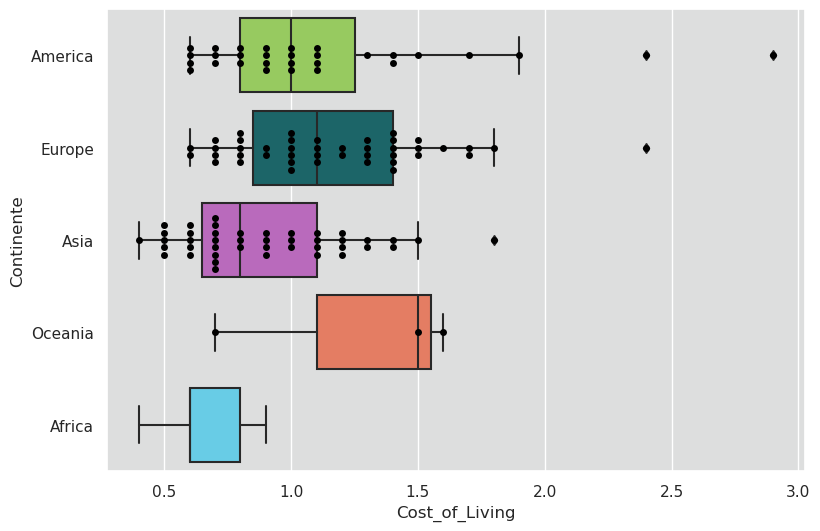

In [96]:
sns.boxplot(
    data = df_cost,
    x = 'Cost_of_Living',
    y = 'Continente',
    palette = continent_color
)

sns.swarmplot(
    data = df_cost,
    x = 'Cost_of_Living',
    y = 'Continente',
    color = 'black'
)

# Remove Outliers 

In [97]:
%run pandas-missing-extension.ipynb #New objet to analyze missing data

In [98]:
def Remove_Outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [99]:
outliers = Remove_Outlier(df_cost)
out_cost = df_cost[outliers]

/tmp/ipykernel_940/1591930294.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
/tmp/ipykernel_940/1591930294.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
/tmp/ipykernel_940/1591930294.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))


In [100]:
out_cost[['Local_Purchasing_Power','Continente']]

,Local_Purchasing_Power,Continente
0,75.9,America
1,110.8,Europe
2,71.4,America
3,37.4,America
4,100.4,Europe
...,...,...
135,31.6,Africa
136,9.4,Africa
137,61.7,Asia
138,17.4,Africa


In [101]:
(
    out_cost
    .isnull()
    .sum()
)

Country                    0
Cost_of_Living             3
Rent                      11
Cost_Plus_Rent             4
Groceries                  3
Restaurant_Price           7
Local_Purchasing_Power     1
Continente                 2
dtype: int64

In [102]:
(
    out_cost
    .isnull()
    .sum()
    .sum()
)

31

## Visualization missing values

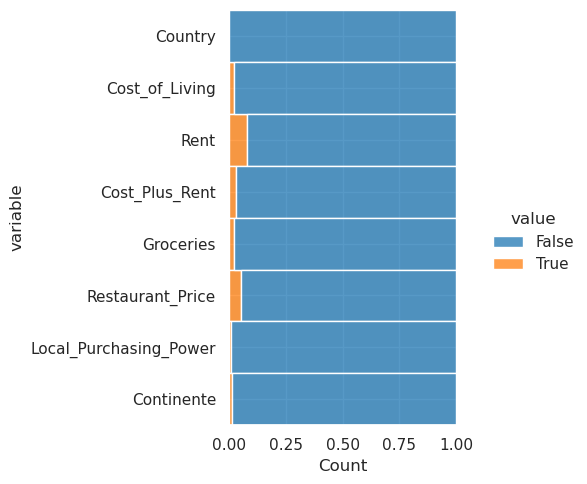

In [103]:
(
    out_cost
    .isnull()
    .melt()
    .pipe(
        lambda df:(
            sns.displot(
                data = df,
                y = 'variable',
                hue = 'value',
                multiple = 'fill'
            )
        )
    )
)

> Rent variable is more missing than the others variables

<Axes: >

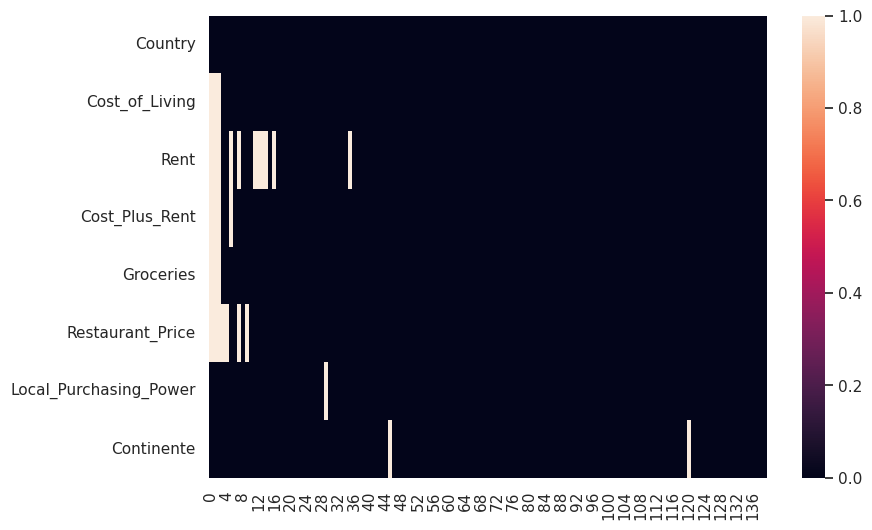

In [104]:
(
    out_cost
    .isnull()
    .transpose()
    .pipe(
        lambda df:(
            sns.heatmap(
                data = df
            )
        )
    )
)

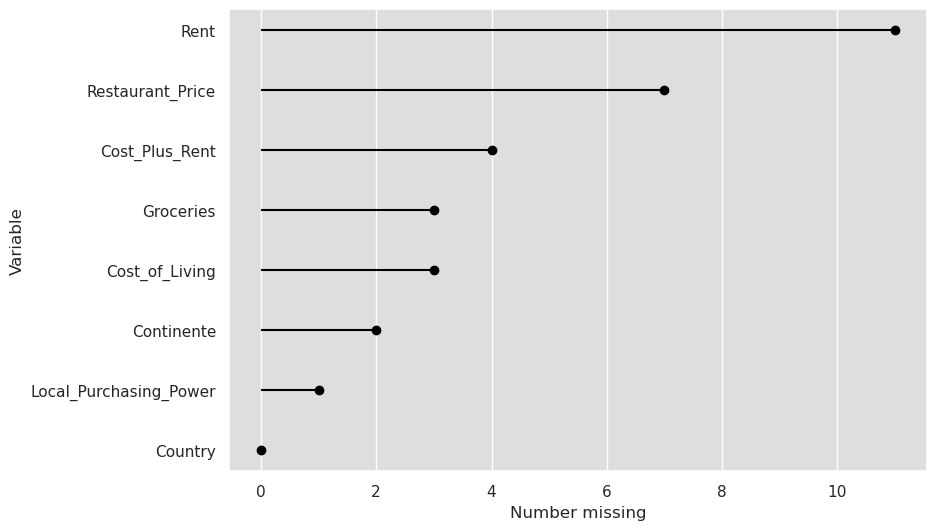

In [105]:
out_cost.missing.missing_variable_plot()

## Missigno to look missing value 

<Axes: >

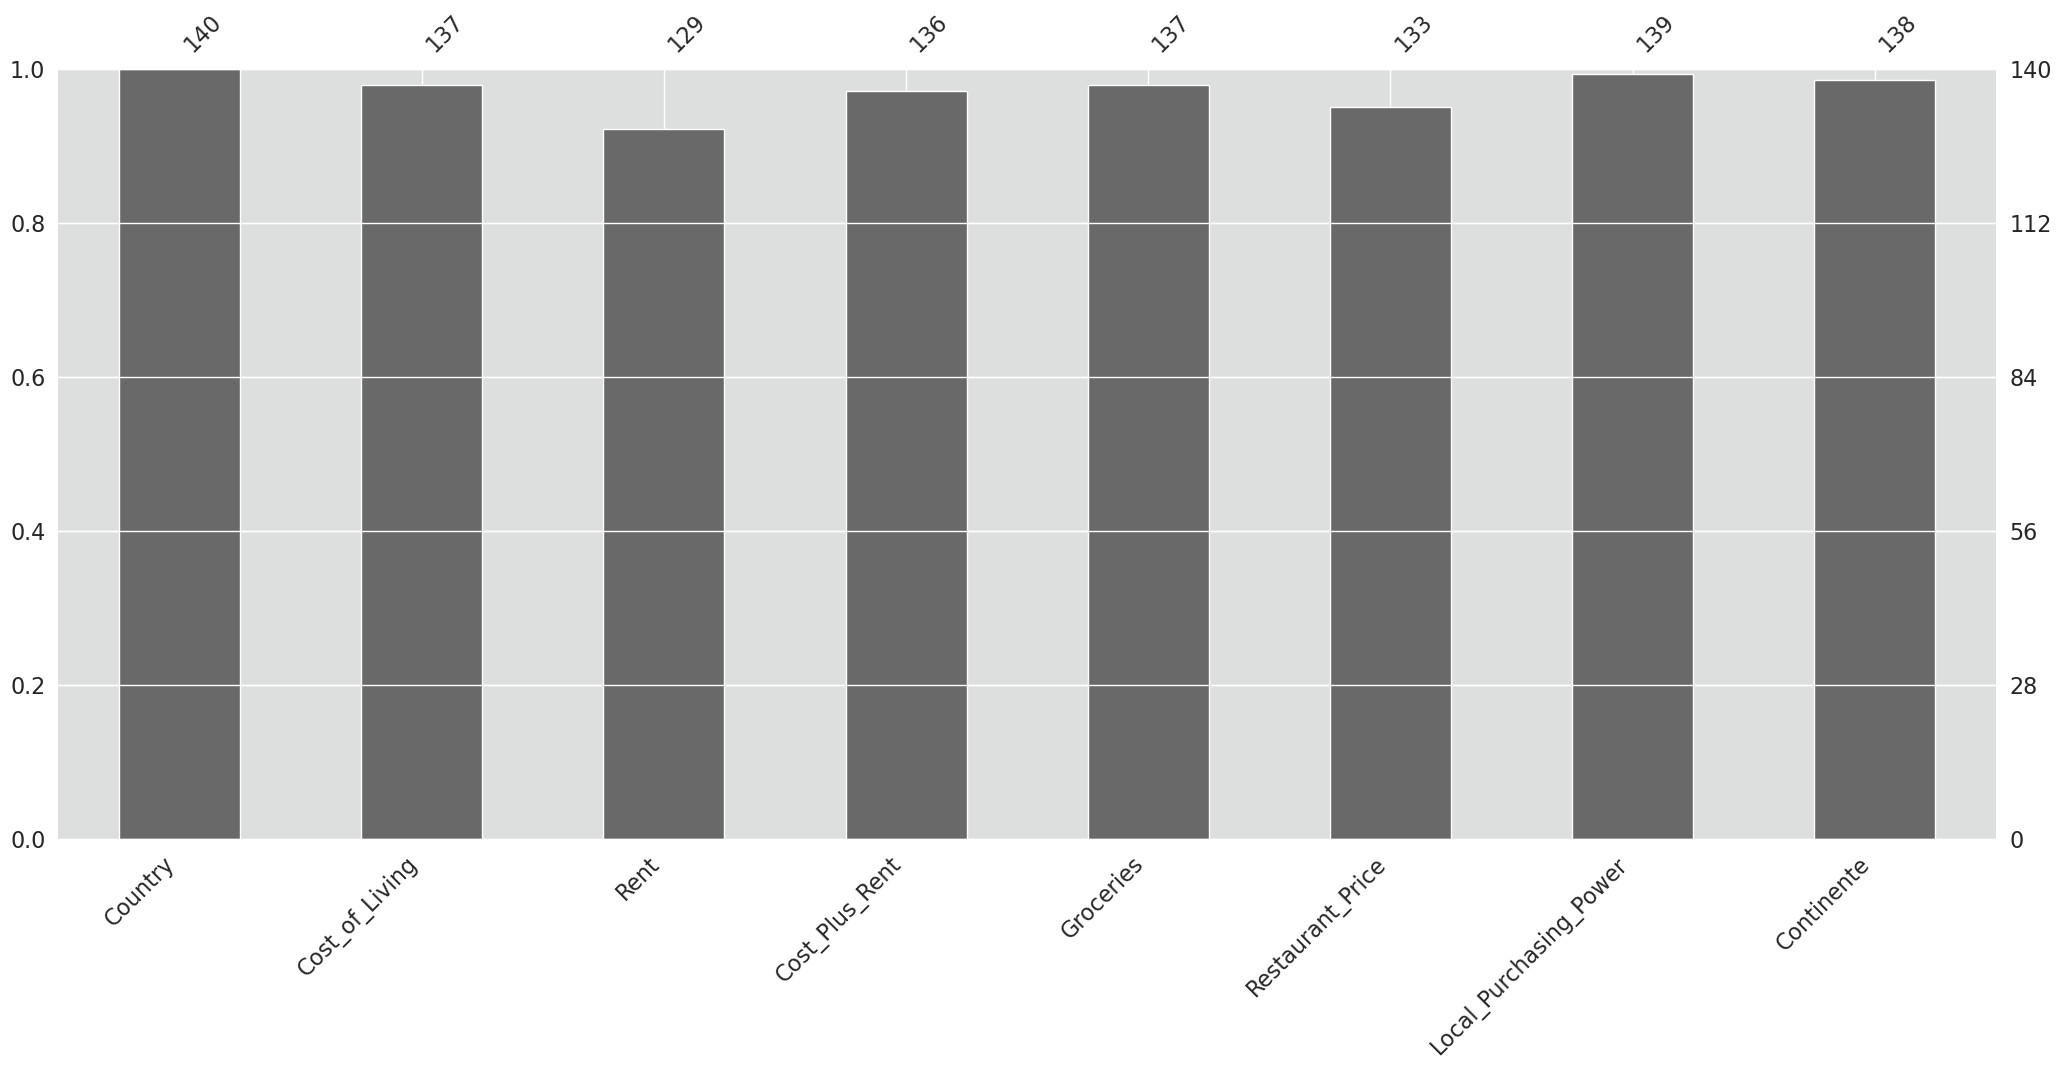

In [106]:
missingno.bar(df = out_cost)

<Axes: >

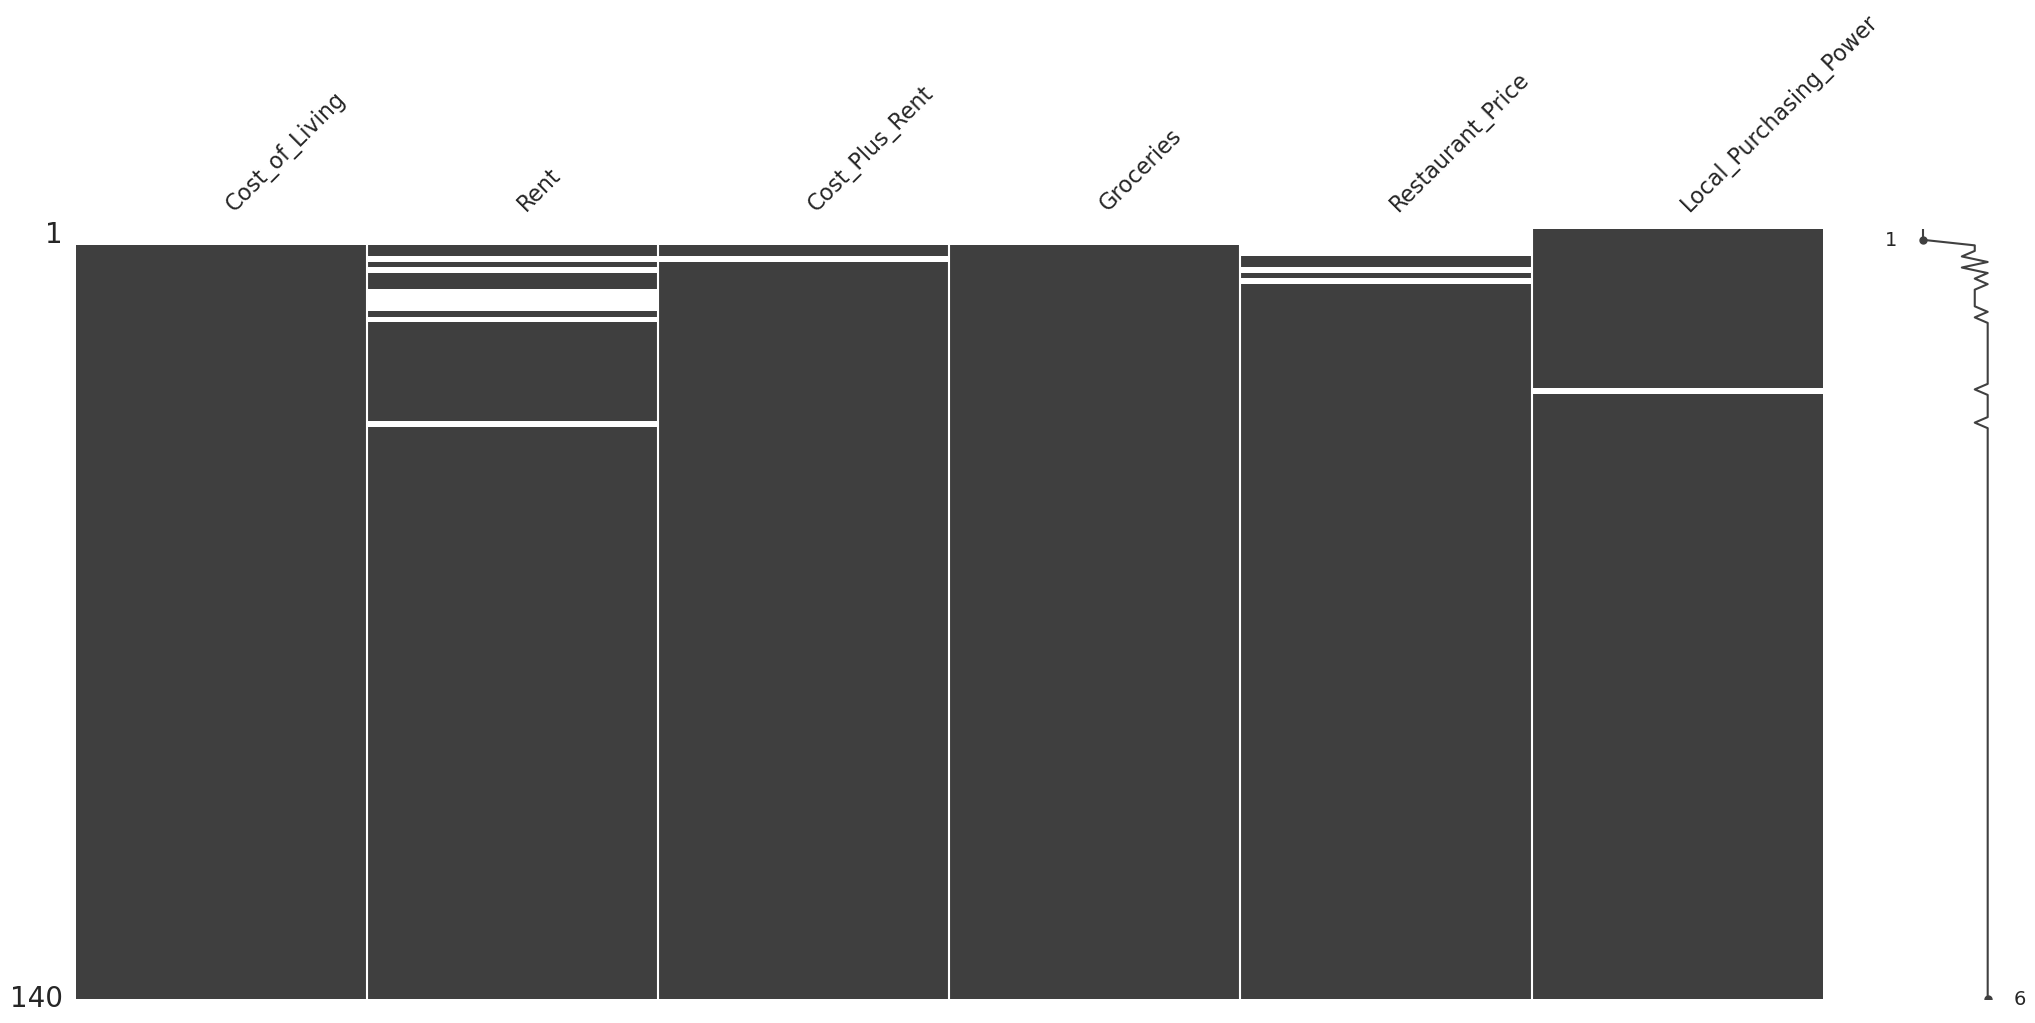

In [107]:
missingno.matrix(df = out_cost.select_dtypes(np.number))

# Heatmap

> Create a Heatmap before scatterplot, because we need to know which ones have more relation

/tmp/ipykernel_940/707277866.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  upp_mat = np.triu(out_cost.corr())
/tmp/ipykernel_940/707277866.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = out_cost.corr(),
/home/edwlearn/anaconda3/envs/best/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

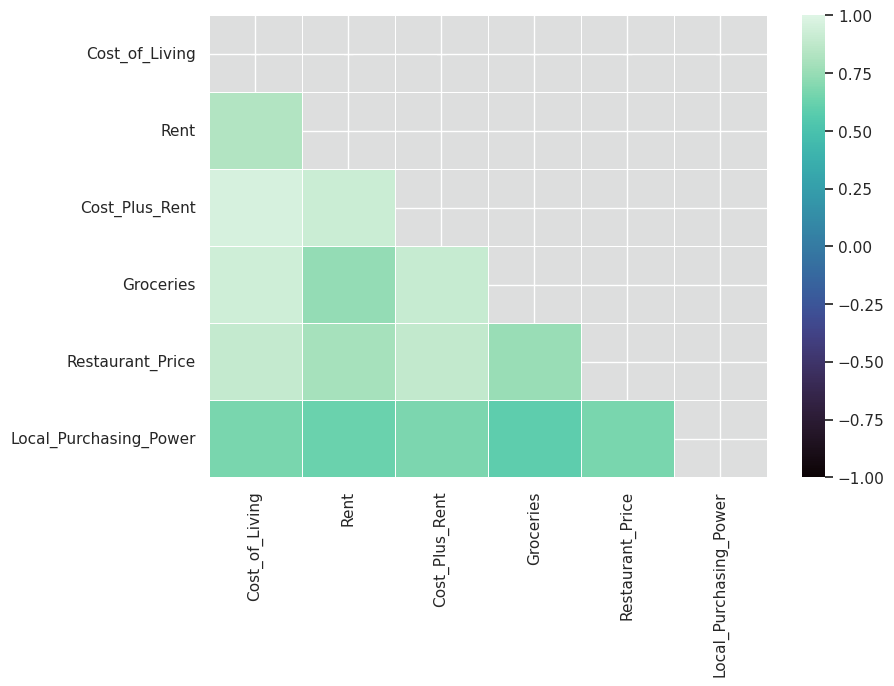

In [108]:
upp_mat = np.triu(out_cost.corr())

sns.heatmap(
    data = out_cost.corr(), 
    cmap='mako',
     center = 0,
     vmin = -1,
     vmax = 1,
     annot = True,
     linewidths= 0.5,
     mask = upp_mat
)

> 'Local_Purchasing_Power' is the variable with more correlation, this observation is powerful, because now we can focus into it

# Correlations

## Cost_of_Living ~

### Restaurant Price

<Axes: xlabel='Restaurant_Price', ylabel='Cost_of_Living'>

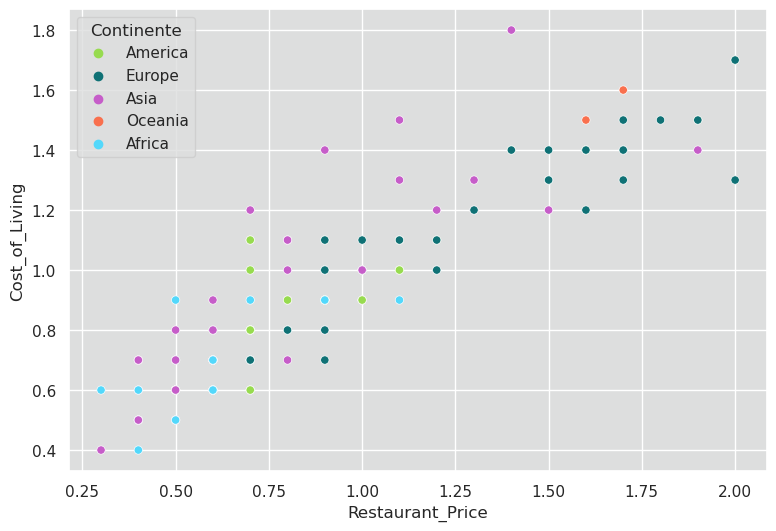

In [109]:
sns.scatterplot(
    data = out_cost,
    x = 'Restaurant_Price',
    y = 'Cost_of_Living',
    hue = 'Continente',
    palette= continent_color
)

As is logical, if cost of life is upper, the restaurant price increase too

### Groceries 

<Axes: xlabel='Groceries', ylabel='Cost_of_Living'>

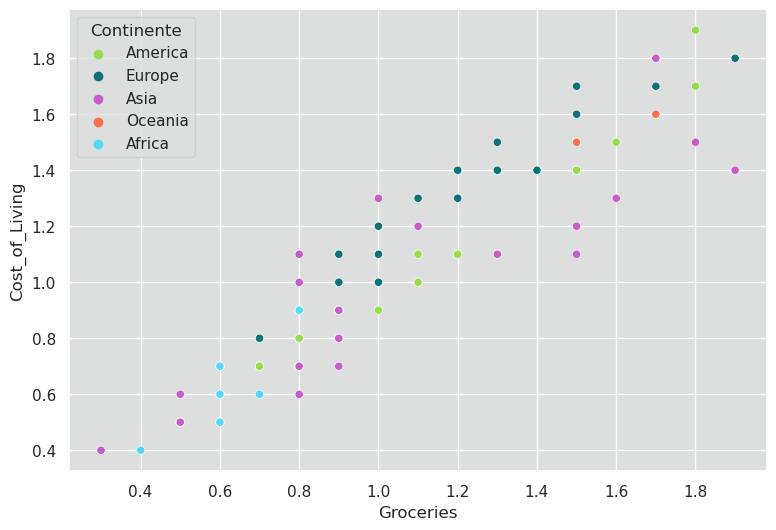

In [110]:
sns.scatterplot(
    data = out_cost,
    x = 'Groceries',
    y = 'Cost_of_Living',
    hue = 'Continente',
    palette= continent_color
)

### Rent

<Axes: xlabel='Rent', ylabel='Cost_of_Living'>

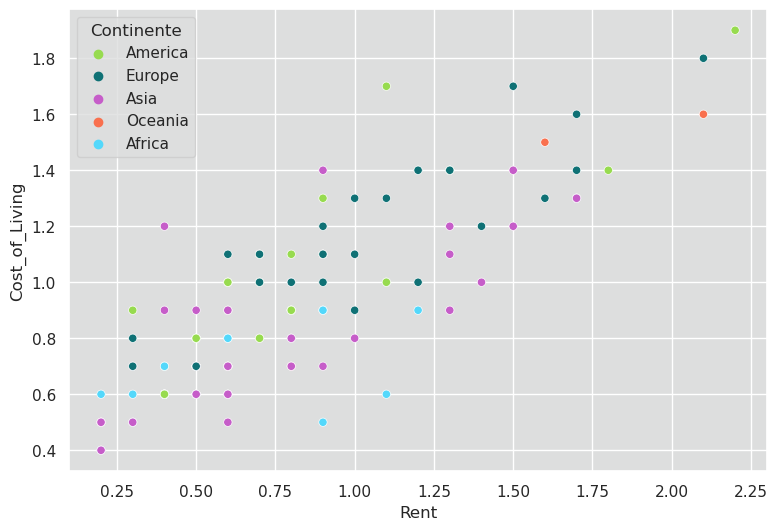

In [111]:
sns.scatterplot(
    data = out_cost,
    x = 'Rent',
    y = 'Cost_of_Living',
    hue = 'Continente',
    palette= continent_color
)

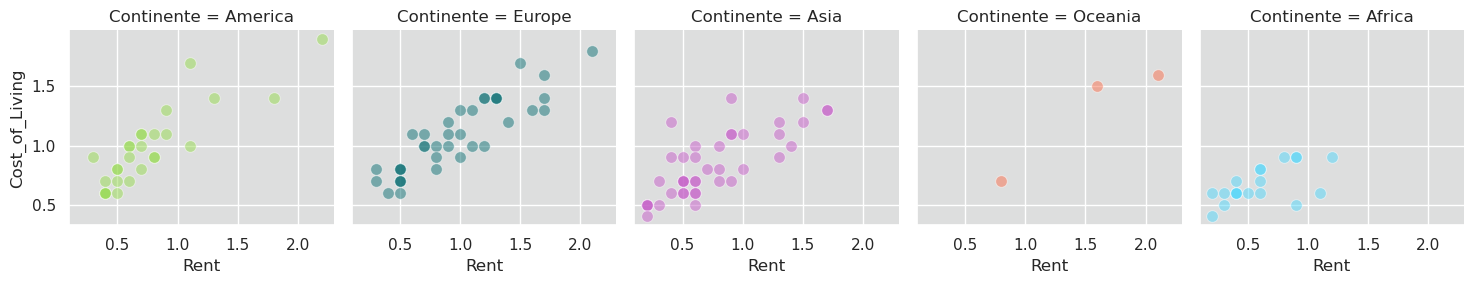

In [112]:
sns.FacetGrid(
    out_cost, 
    col = 'Continente', 
    hue= 'Continente',
    palette= continent_color
    ).map(sns.scatterplot,
        'Rent',
        'Cost_of_Living',
        alpha= 1/2,
        s= 70
        )

> We separate by 'Continente' for better visualization. We can conclude that 'Cost_of_Living' have a correlation with the other variables

### Local_Purchasing_Power

<Axes: xlabel='Cost_of_Living', ylabel='Local_Purchasing_Power'>

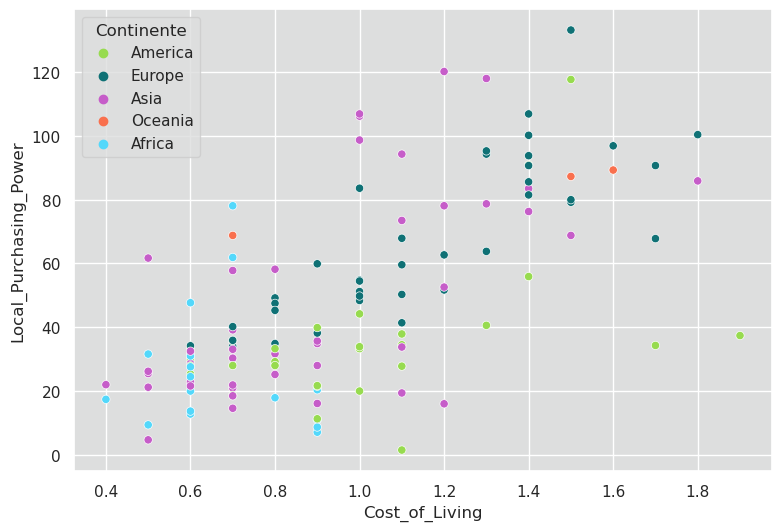

In [113]:
sns.scatterplot(
    data = out_cost,
    x = 'Cost_of_Living',
    y = 'Local_Purchasing_Power',
    hue = 'Continente',
    palette= continent_color
)

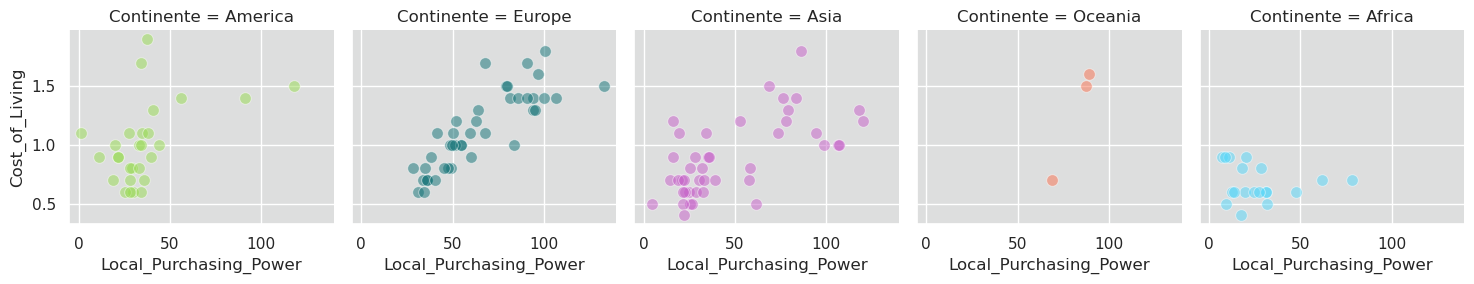

In [114]:
sns.FacetGrid(
    out_cost, 
    col = 'Continente', 
    hue= 'Continente',
    palette= continent_color
    ).map(sns.scatterplot,
        'Local_Purchasing_Power',
        'Cost_of_Living',
        alpha= 1/2,
        s= 70
        )

> In the heatmap we could see that 'Local_Purchasing_Power' have low correlation than the other variables, but in the visualization we can conclude that this variable also have correlation and this have more impact in some continents.

Some continent like America and Africa don't continue the tendency, but the others variables do.

## Rent ~

### Local_Purchasing_Power

<Axes: xlabel='Local_Purchasing_Power', ylabel='Rent'>

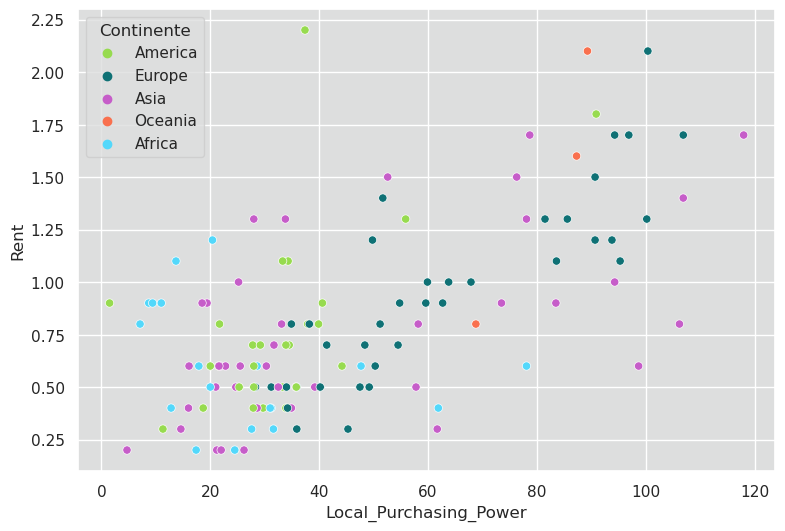

In [115]:
sns.scatterplot(
    out_cost,
    x = 'Local_Purchasing_Power',
    y = 'Rent',
    hue = 'Continente',
    palette = continent_color
)

> We continue seeing that 'Local_Purchasing_Power' have a lot of importance

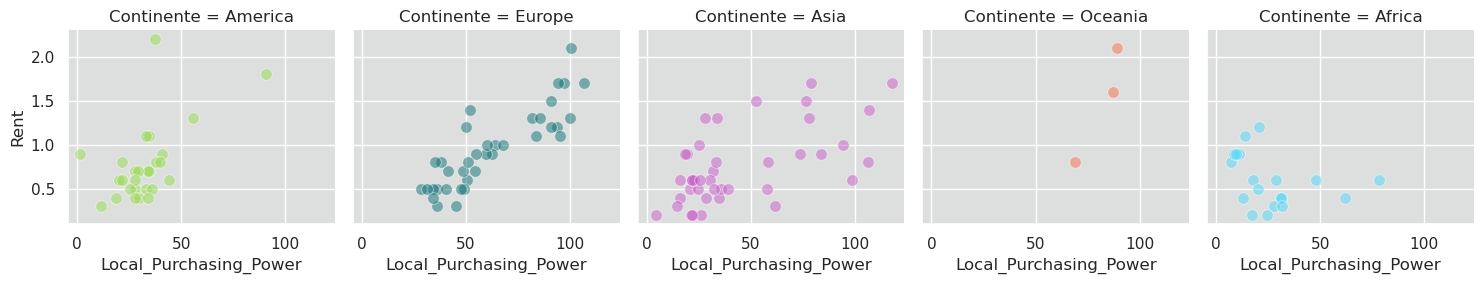

In [116]:
sns.FacetGrid(
    data = out_cost,
    col = 'Continente',
    hue = 'Continente',
    palette= continent_color
).map(
    sns.scatterplot,
    'Local_Purchasing_Power',
    'Rent',
    alpha = 1/2,
    s = 70
)

## Groceries ~

### Rent

<Axes: xlabel='Rent', ylabel='Groceries'>

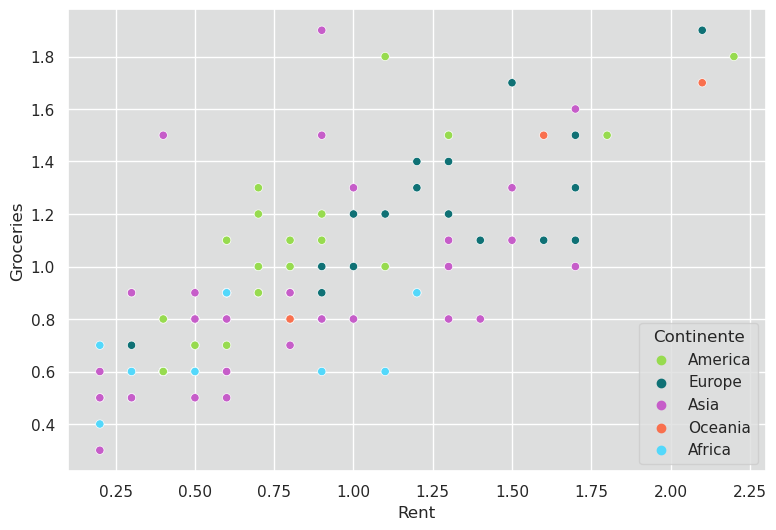

In [117]:
sns.scatterplot(
    out_cost,
    x = 'Rent',
    y = 'Groceries',
    hue = 'Continente',
    palette= continent_color
)

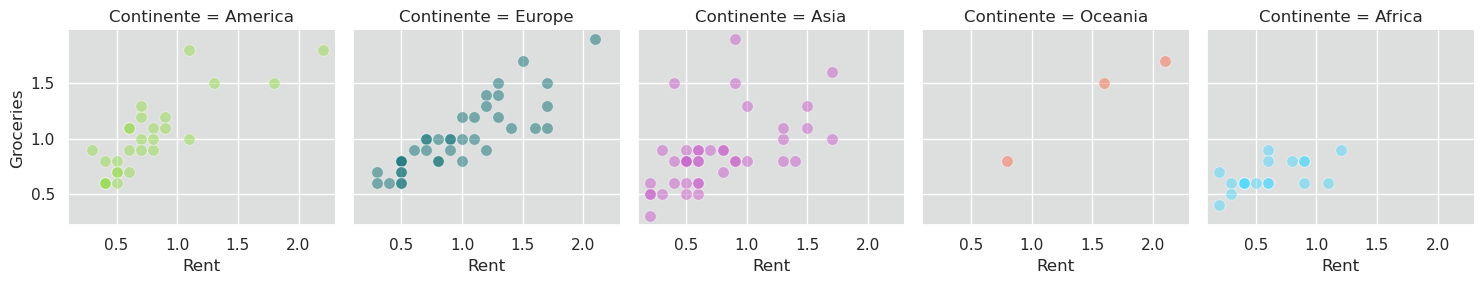

In [118]:
sns.FacetGrid(
    out_cost,
    col = 'Continente',
    hue = 'Continente',
    palette= continent_color
).map(
    sns.scatterplot,
    'Rent',
    'Groceries',
    alpha = 1/2,
    s = 70
    )

> Most variables have a linear correlation because  it belongs at same dataset (In this case). Some variables like 'Local_Purchasing_Power' has a more important correlation 

# Question About Variable

## Per Continent

In [119]:
df_america = df_cost[df_cost['Continente'] == 'America']
df_europe = df_cost[df_cost['Continente'] == 'Europe']
df_asia = df_cost[df_cost['Continente'] == 'Asia']
df_oceania = df_cost[df_cost['Continente'] == 'Oceania']
df_africa = df_cost[df_cost['Continente'] == 'Africa']

> Separate into their respective continents

## America

- Top 5 best and less Cost_of_Living

In [120]:
expensive_ame = df_america.sort_values(by = ['Cost_of_Living'], ascending= False).head(5)
cheapest_ame = df_america.sort_values(by = ['Cost_of_Living'], ascending= False).tail(5)

<Axes: xlabel='Country', ylabel='Cost_of_Living'>

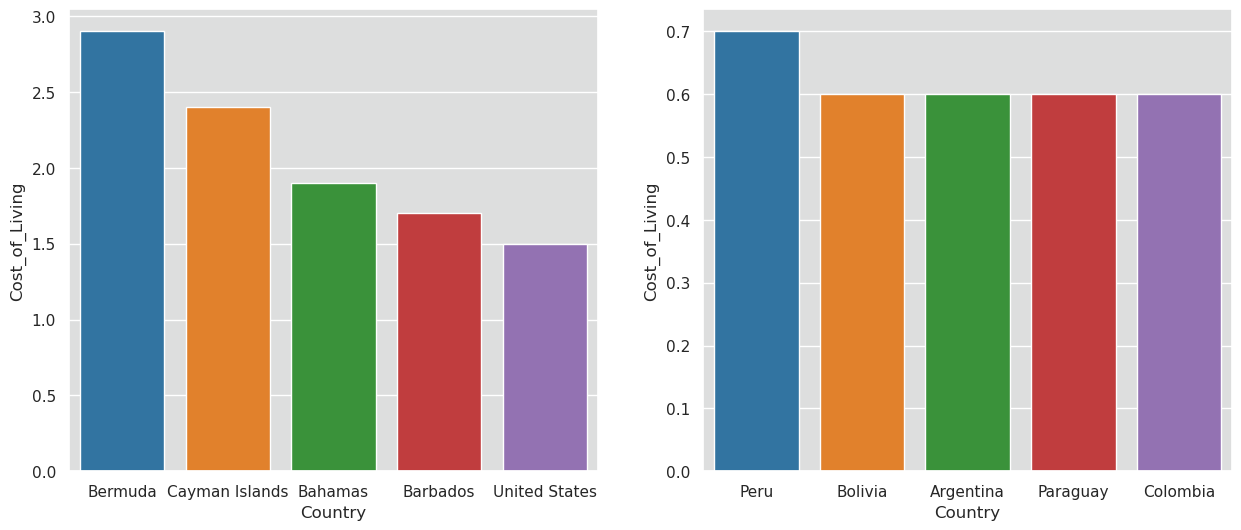

In [121]:
fig, ax = plt.subplots(1,2,figsize = (15,6))

sns.barplot(
    expensive_ame,
    x = 'Country',
    y = 'Cost_of_Living',
    ax = ax[0]
)

sns.barplot(
    cheapest_ame,
    x = 'Country',
    y = 'Cost_of_Living',
    ax = ax[1]
)

Bermuda is the most expensive country to live in America and World, It is 41.8% expensive than New York City
Colombia is the cheapest country to live. It's 76.9% less than New York City

- Best Country (Talking about cost)

In [122]:
print(f' America:{df_america.shape} \n Europa:{df_europe.shape} \n Asia:{df_asia.shape} \n Africa:{df_africa.shape} \n World:{df_cost.shape}' )

 America:(30, 8) 
 Europa:(43, 8) 
 Asia:(43, 8) 
 Africa:(19, 8) 
 World:(140, 8)


In [123]:
ame = (
    df_america['Country']
    .pipe(lambda df:(
        np.floor(df.count() / 2))
    )
).astype(int)

eur = (
    df_europe['Country']
    .pipe(lambda df:(
        np.floor(df.count() / 2))
    )
).astype(int)

asi = (
    df_asia['Country']
    .pipe(lambda df:(
        np.floor(df.count() / 2))
    )
).astype(int)

afr = (
    df_africa['Country']
    .pipe(lambda df:(
        np.floor(df.count() / 2))
    )
).astype(int)

It makes for each continent divide by 2, but some odd number of countries. For that reason 'floor' round this

In [124]:
def div(df):
    n = (
        df['Country']
        .pipe(lambda df:(
            np.floor(df.count() / 2))
        )
    ).astype(int)
    return n

This function has the same functionality as before code

## America

In [125]:
# lowest_cost_ame = df_america.sort_values('Cost_of_Living', ascending=True).head(div(df_america))
# highest_local_ame = df_america.sort_values('Local_Purchasing_Power', ascending=False).head(div(df_america))
# highest_local_ame[['Country', 'Cost_of_Living', 'Local_Purchasing_Power']].sort_values('Local_Purchasing_Power', ascending=False)
# # cost_countries_ame = lowest_cost_ame[lowest_cost_ame.isin(highest_local_ame)].dropna()
# #cost_countries_ame[['Country', 'Cost_of_Living', 'Local_Purchasing_Power']].sort_values('Local_Purchasing_Power', ascending=False)


# lowest_rent_ame = df_america.sort_values('Rent', ascending=True).head(div(df_america))
# rent_ame = lowest_rent_ame[lowest_rent_ame.isin(cost_countries_ame)].dropna()

# lowest_groceries_ame = df_america.sort_values('Groceries', ascending= True).head(div(df_america))
# groceries_ame = lowest_groceries_ame[lowest_groceries_ame.isin(rent_ame)].dropna()
# groceries_ame[['Country', 'Cost_of_Living', 'Local_Purchasing_Power']].sort_values('Local_Purchasing_Power', ascending=False)

### I was creating a interseption, between a lowest cost and higest purchasing power. But that had a problem, just filter the middle, suposse if a country have higest local_Purchasing_power than cost of living mean that you can live 'free'


In [126]:
df_america['Difference'] = df_america['Local_Purchasing_Power'] - df_america['Cost_Plus_Rent']

df_america.head()

/tmp/ipykernel_940/314745949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_america['Difference'] = df_america['Local_Purchasing_Power'] - df_america['Cost_Plus_Rent']


,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power,Continente,Difference
0,Bermuda,2.9,5.0,3.4,3.3,3.3,75.9,America,72.5
2,Cayman Islands,2.4,4.3,2.9,2.4,2.4,71.4,America,68.5
3,Bahamas,1.9,2.2,2.0,1.8,2.2,37.4,America,35.4
6,Barbados,1.7,1.1,1.6,1.8,2.0,34.3,America,32.7
11,United States,1.5,2.5,1.8,1.6,1.9,117.7,America,115.9


In [127]:
df_cost_des['Difference'] = df_cost_des['Local_Purchasing_Power'] - df_cost_des['Cost_Plus_Rent']

df_cost_des.head()

,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power,Difference
0,Bermuda,141.1,93.0,118.2,143.8,141.2,75.9,-42.3
1,Switzerland,117.3,50.6,85.6,114.2,111.9,110.8,25.2
2,Cayman Islands,115.4,79.9,98.5,104.8,103.0,71.4,-27.1
3,Bahamas,93.7,40.8,68.5,77.9,93.7,37.4,-31.1
4,Iceland,87.7,39.4,64.7,83.9,93.4,100.4,35.7


In [128]:
# Filtrar países donde el Local_Purchasing_Power es mayor que el Cost_of_Living
lowest_price_americas = (
    df_america[df_america['Local_Purchasing_Power'] > df_america['Cost_Plus_Rent']]
)

# filter countries that have a low groceries cost
lowest_groceries_americas = df_america.sort_values('Groceries', ascending=True).head(15)

best_countries_americas  = lowest_groceries_americas[lowest_groceries_americas.isin(lowest_price_americas)].dropna()

best_countries_americas 


,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power,Continente,Difference
128,Colombia,0.6,0.4,0.5,0.6,0.5,27.9,America,27.4
117,Argentina,0.6,0.4,0.6,0.6,0.7,33.9,America,33.3
113,Bolivia,0.6,0.4,0.6,0.6,0.5,29.7,America,29.1
122,Paraguay,0.6,0.5,0.6,0.6,0.5,25.3,America,24.7
103,Peru,0.7,0.6,0.7,0.7,0.6,28.0,America,27.3
101,Ecuador,0.7,0.5,0.6,0.7,0.6,35.8,America,35.2
89,Brazil,0.8,0.5,0.7,0.7,0.7,28.0,America,27.3
97,Nicaragua,0.7,0.4,0.6,0.8,0.6,18.7,America,18.1
90,Honduras,0.8,0.5,0.7,0.8,0.7,33.3,America,32.6
87,Guatemala,0.8,0.7,0.8,0.9,0.7,29.2,America,28.4


In [129]:
best_countries_americas.head(5)

,Country,Cost_of_Living,Rent,Cost_Plus_Rent,Groceries,Restaurant_Price,Local_Purchasing_Power,Continente,Difference
128,Colombia,0.6,0.4,0.5,0.6,0.5,27.9,America,27.4
117,Argentina,0.6,0.4,0.6,0.6,0.7,33.9,America,33.3
113,Bolivia,0.6,0.4,0.6,0.6,0.5,29.7,America,29.1
122,Paraguay,0.6,0.5,0.6,0.6,0.5,25.3,America,24.7
103,Peru,0.7,0.6,0.7,0.7,0.6,28.0,America,27.3


Se crea una intersección entre los paises que tenga un costo de vida bajo, pero con un poder adquisitivo alto. Eso quiere decir: Paises baratos dónde se gane bastante. 

A ese filtro se le agregan las demás variables, that have low groceries prices

### Top 5 best country lo live in America (Talking about cost) are:  
1. Paraguay
2. Argentina
3. Colombia
4. Bolivia
5. Ecuador

We take mainly 'Cost_Plus_Rent' and 'Local Purchasing' To compare, to that filter add 'Groceries' to have a broader perspective. 

## Europe

In [130]:
best_countries_europe = df_europe[df_europe['Local_Purchasing_Power'] > df_europe['Cost_Plus_Rent']]

# best_countries_europe
df_europe.count()

Country                   43
Cost_of_Living            43
Rent                      43
Cost_Plus_Rent            43
Groceries                 43
Restaurant_Price          43
Local_Purchasing_Power    43
Continente                43
dtype: int64

In [131]:
lowest_cost_eur = df_europe.sort_values('Cost_Plus_Rent',ascending= True).head(div(df_europe))
highest_local_eur = df_europe.sort_values('Local_Purchasing_Power', ascending=False).head(div(df_europe))
highest_local_eur[['Country', 'Cost_of_Living', 'Local_Purchasing_Power']].sort_values('Local_Purchasing_Power', ascending=False)

cost_countries_eur = lowest_cost_eur[lowest_cost_eur.isin(highest_local_eur)].dropna()
cost_countries_eur['Country']

# lowest_rent_eur = df_europe.sort_values('Rent', ascending= True).head(div(df_europe))
# rent_eur = lowest_rent_eur[lowest_rent_eur.isin(cost_countries_eur)].dropna()
# # rent_eur['Country']
# #lowest_rent_eur['Country']

# lowest_groceries_eur = df_europe.sort_values('Groceries', ascending= True).head(div(df_europe))
# groceries_eur = lowest_groceries_eur[lowest_groceries_eur.isin(rent_eur)].dropna()
# groceries_eur['Country']



Series([], Name: Country, dtype: object)

## Asia

In [132]:
lowest_cost_asi = df_asia.sort_values('Cost_of_Living',ascending= True).head(div(df_asia))
highest_local_asi = df_asia.sort_values('Local_Purchasing_Power', ascending=False).head(div(df_asia))

cost_countries_asi = lowest_cost_asi[lowest_cost_asi.isin(highest_local_asi)].dropna()

lowest_rent_asi = df_asia.sort_values('Rent', ascending= True).head(div(df_asia))
rent_asi = lowest_rent_asi[lowest_rent_asi.isin(cost_countries_asi)].dropna()

lowest_groceries_asi = df_asia.sort_values('Groceries', ascending= True).head(div(df_asia))
groceries_asi = lowest_groceries_asi[lowest_groceries_asi.isin(rent_asi)].dropna()
groceries_asi[['Country', 'Cost_of_Living', 'Local_Purchasing_Power','Rent','Groceries']].sort_values('Local_Purchasing_Power', ascending=False)

,Country,Cost_of_Living,Local_Purchasing_Power,Rent,Groceries
137,India,0.5,61.7,0.3,0.5
108,Malaysia,0.7,57.8,0.5,0.8
105,Iraq,0.7,39.2,0.5,0.6


## Africa

In [133]:
lowest_cost_afri = df_africa.sort_values('Cost_of_Living',ascending= True).head(div(df_africa))
highest_local_afri = df_africa.sort_values('Local_Purchasing_Power', ascending=False).head(div(df_africa))

cost_countries_afri = lowest_cost_afri[lowest_cost_afri.isin(highest_local_afri)].dropna()

lowest_rent_afri = df_africa.sort_values('Rent', ascending= True).head(div(df_africa))
rent_afri = lowest_rent_afri[lowest_rent_afri.isin(cost_countries_afri)].dropna()

lowest_groceries_afri = df_africa.sort_values('Groceries', ascending= True).head(div(df_africa))
groceries_afri = lowest_groceries_afri[lowest_groceries_afri.isin(rent_afri)].dropna()
groceries_afri['Country']

135      Libya
129    Tunisia
124      Kenya
118    Morocco
Name: Country, dtype: object

## World

In [134]:
lowest_cost_world = df_cost.sort_values('Cost_of_Living',ascending= True).head(div(df_cost))
highest_local_world = df_cost.sort_values('Local_Purchasing_Power', ascending=False).head(div(df_cost))

cost_countries_world = lowest_cost_world[lowest_cost_world.isin(highest_local_world)].dropna()

lowest_rent_world = df_cost.sort_values('Rent', ascending= True).head(div(df_cost))
rent_world = lowest_rent_world[lowest_rent_world.isin(cost_countries_world)].dropna()

lowest_groceries_world = df_cost.sort_values('Groceries', ascending= True).head(div(df_cost))
groceries_world = lowest_groceries_world[lowest_groceries_world.isin(rent_world)].dropna()
print(groceries_world[['Country', 'Cost_of_Living', 'Local_Purchasing_Power']])


                    Country  Cost_of_Living  Local_Purchasing_Power
137                   India             0.5                    61.7
111                 Namibia             0.6                    47.7
109                  Russia             0.7                    40.2
105                    Iraq             0.7                    39.2
98             South Africa             0.7                    78.1
110                Botswana             0.7                    61.9
91   Bosnia And Herzegovina             0.8                    45.3
84                 Bulgaria             0.8                    49.2
108                Malaysia             0.7                    57.8
88                  Romania             0.8                    47.5


<Axes: xlabel='Cost_of_Living', ylabel='Continente'>

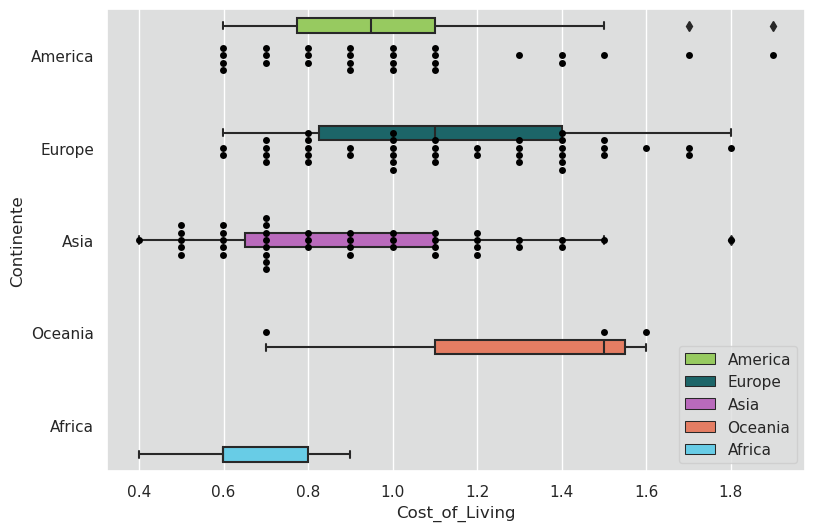

In [135]:
sns.boxplot(
    data = out_cost,
    x = 'Cost_of_Living',
    y = 'Continente',
    hue = 'Continente',
    palette= continent_color
)

sns.swarmplot(
    data = out_cost,
    x = 'Cost_of_Living',
    y = 'Continente',
    color = 'black'
)

> We are seeing that 'America' have longer deviation than the others continents, continue by 'Europe'

<Axes: xlabel='Cost_of_Living', ylabel='Continente'>

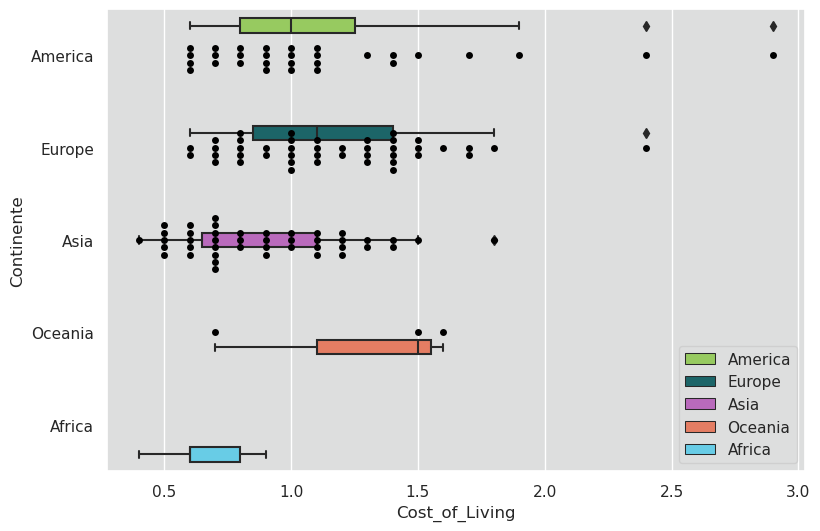

In [136]:
sns.boxplot(
    data = df_cost,
    x = 'Cost_of_Living',
    y = 'Continente',
    hue = 'Continente',
    palette= continent_color
)

sns.swarmplot(
    data = df_cost,
    x = 'Cost_of_Living',
    y = 'Continente',
    color = 'black'
)

In [137]:
import altair as alt

alt.Chart(df_cost).mark_boxplot().encode(
    x='Cost_of_Living',
    y='Continente',
    color = 'Continente',
    tooltip=['Country', 'Cost_of_Living']
).interactive().properties(
    width=600,
    height=400
)

/home/edwlearn/anaconda3/envs/best/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [138]:
alt.Chart(out_cost).mark_boxplot().encode(
    x='Cost_of_Living',
    y='Continente',
    color = 'Continente',
    tooltip=['Country', 'Cost_of_Living']
).interactive().properties(
    width=600,
    height=400
)

alt.Chart(...)

> Altair is a visualization library, it needs less line codes to graph. We use this library in this occasion because we want to see what counties are outliers:

Cayman Islands, Bermuda, Switzerland 

# Probability Distributions: PMFs, CDFs y PDFs

## Mass Probability Function (PMFs)

### Using Seaborn

<Axes: xlabel='Local_Purchasing_Power', ylabel='Probability'>

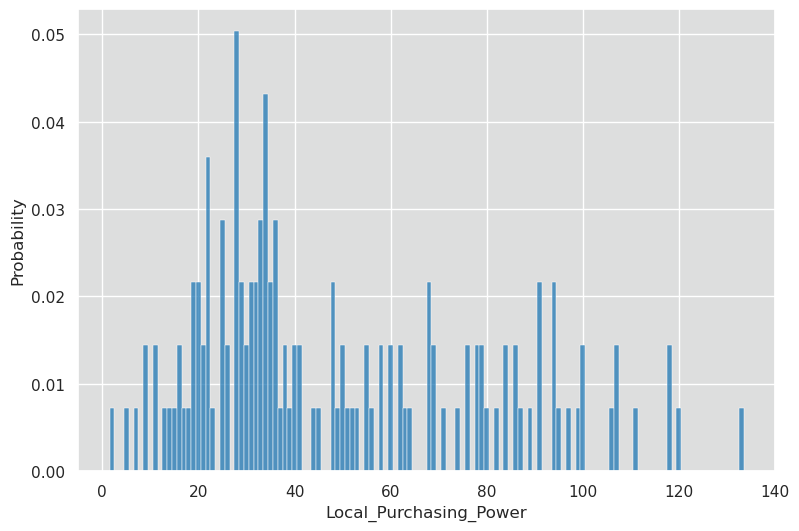

In [139]:
sns.histplot(
    data = out_cost,
    x = 'Local_Purchasing_Power',
    binwidth= 1,
    stat = 'probability'
)

<Axes: xlabel='Cost_of_Living', ylabel='Probability'>

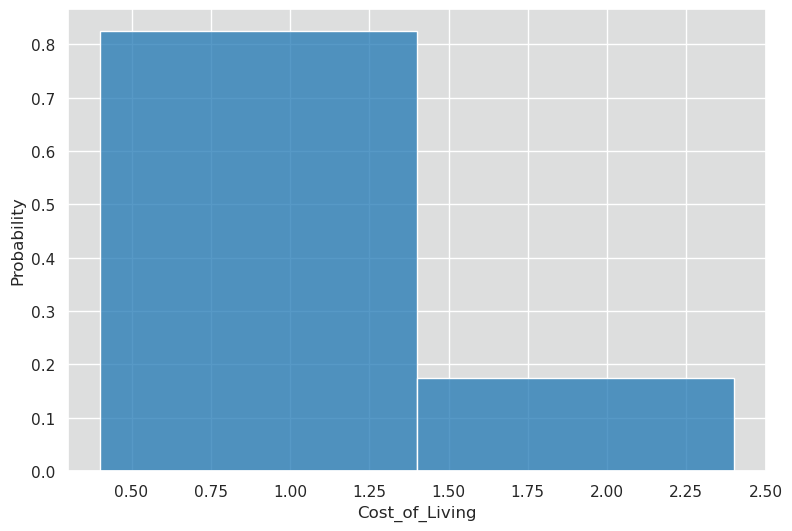

In [140]:
sns.histplot(
    data = out_cost,
    x = 'Cost_of_Living',
    binwidth=1,
    stat= 'probability'
)

### Using Empiricaldist

In [141]:
pmf_purchasing_power = empiricaldist.Pmf.from_seq(
    out_cost['Local_Purchasing_Power'],
    normalize= True
)
pmf_purchasing_power

,probs
1.5,0.007194
4.7,0.007194
7.1,0.007194
8.7,0.007194
9.4,0.007194
...,...
110.8,0.007194
117.7,0.007194
118.0,0.007194
120.2,0.007194


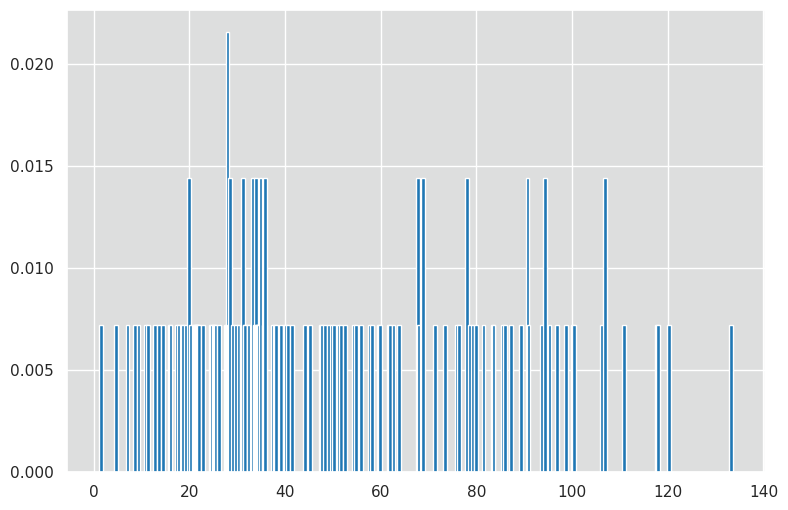

In [142]:
pmf_purchasing_power.bar()

In this case, don´t function empiricaldist to visualization.

In [143]:
pmf_purchasing_power(7.8)

0

## Probability Function acumulada (ECDFs)

> Find a <= value in variable

### Local_Purchasing_Power

#### Using Seaborn

<Axes: xlabel='Local_Purchasing_Power', ylabel='Proportion'>

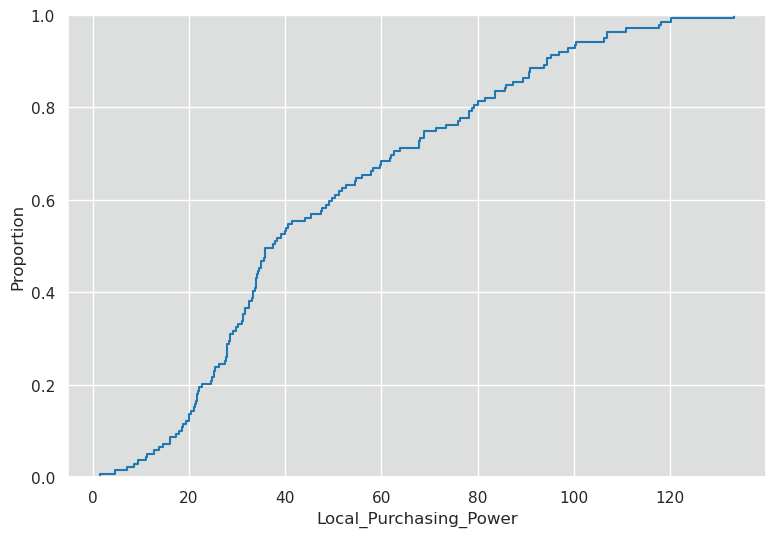

In [144]:
sns.ecdfplot(
    data = out_cost,
    x = 'Local_Purchasing_Power'
)

#### Using empiricaldist

In [145]:
cdf_local_purchasing =empiricaldist.Cdf.from_seq(
    out_cost['Local_Purchasing_Power'],
    normalize= True
)

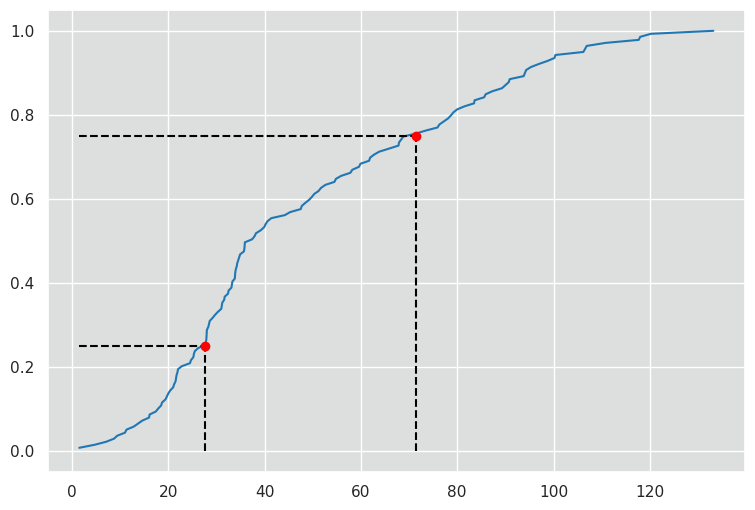

In [146]:
cdf_local_purchasing.plot()

p_1 = 0.25
p_2 = 0.75

ps = (0.25, 0.75)
qs = cdf_local_purchasing.inverse(ps)


plt.vlines(
    x = qs,
    ymin = 0,
    ymax = ps,
    color = 'black',
    linestyle = 'dashed'
)

plt.hlines(
    y = ps,
    xmin = pmf_purchasing_power.qs[0],
    xmax = qs,
    color = 'black',
    linestyle = 'dashed'
)


plt.scatter(
    x= qs,
    y = ps,
    color = 'red',
    zorder = 2
)

### Cost_of_Living

#### Using Seaborn

<Axes: xlabel='Cost_of_Living', ylabel='Proportion'>

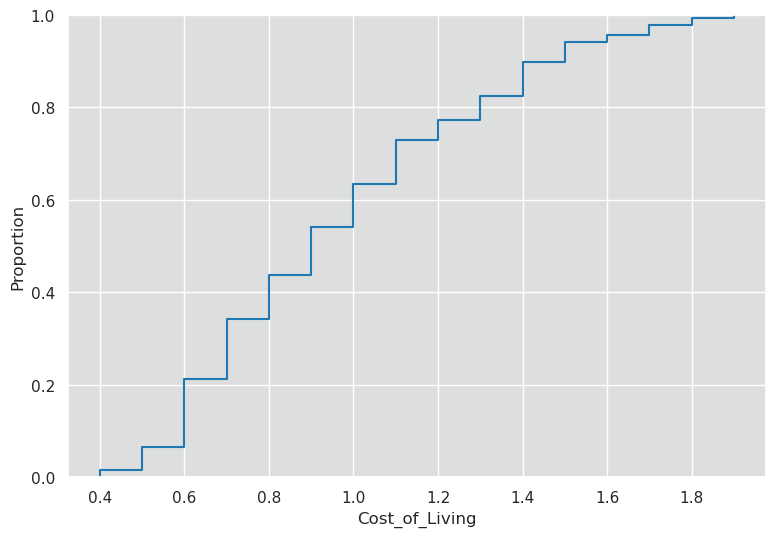

In [147]:
sns.ecdfplot(
    data = out_cost,
    x = 'Cost_of_Living'
)

#### Using empiricaldist

In [148]:
cdf_cost = empiricaldist.Cdf.from_seq(
    out_cost['Cost_of_Living'],
    normalize= True
)

pmf_cost = empiricaldist.Pmf.from_seq(
    out_cost['Cost_of_Living'],
    normalize= True
)

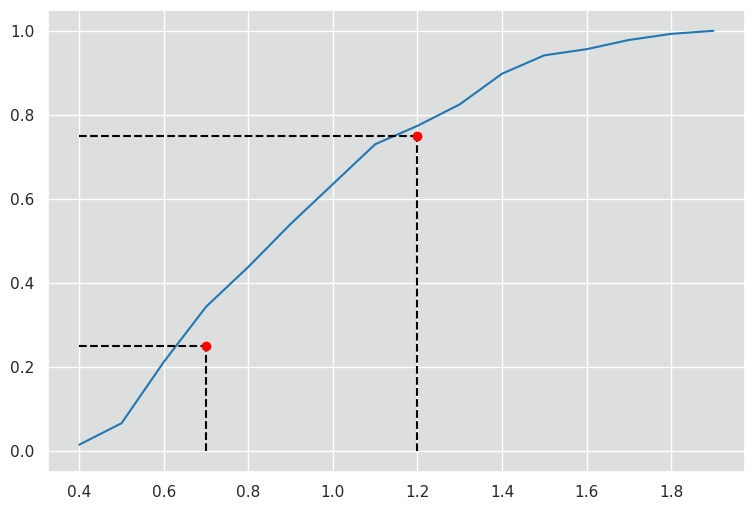

In [149]:
cdf_cost.plot()

p_1 = 0.25
p_2 = 0.75

ps = (0.25, 0.75)
qs = cdf_cost.inverse(ps)


plt.vlines(
    x = qs,
    ymin = 0,
    ymax = ps,
    color = 'black',
    linestyle = 'dashed'
)

plt.hlines(
    y = ps,
    xmin = pmf_cost.qs[0],
    xmax = qs,
    color = 'black',
    linestyle = 'dashed'
)


plt.scatter(
    x= qs,
    y = ps,
    color = 'red',
    zorder = 2
)

### All Continents

<Axes: xlabel='Cost_of_Living', ylabel='Proportion'>

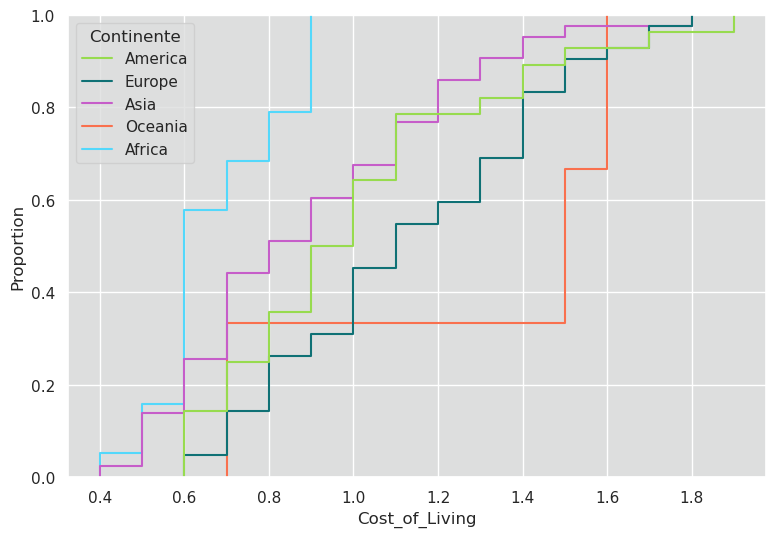

In [150]:
sns.ecdfplot(
    data = out_cost,
    x = 'Cost_of_Living',
    hue = 'Continente',
    palette = continent_color
)

<Axes: xlabel='Local_Purchasing_Power', ylabel='Proportion'>

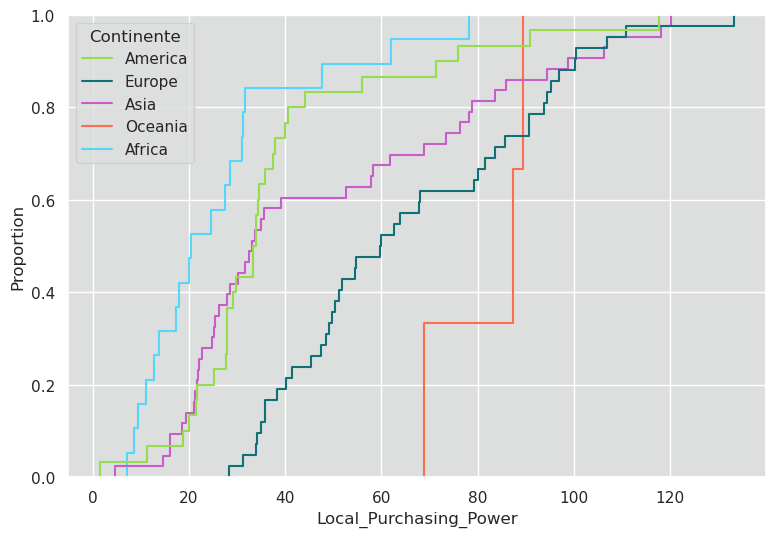

In [151]:
sns.ecdfplot(
    data = out_cost,
    x = 'Local_Purchasing_Power',
    hue = 'Continente',
    palette = continent_color
)

## Probability density function

### Local_Purchasing_Power

<Axes: xlabel='Local_Purchasing_Power', ylabel='Density'>

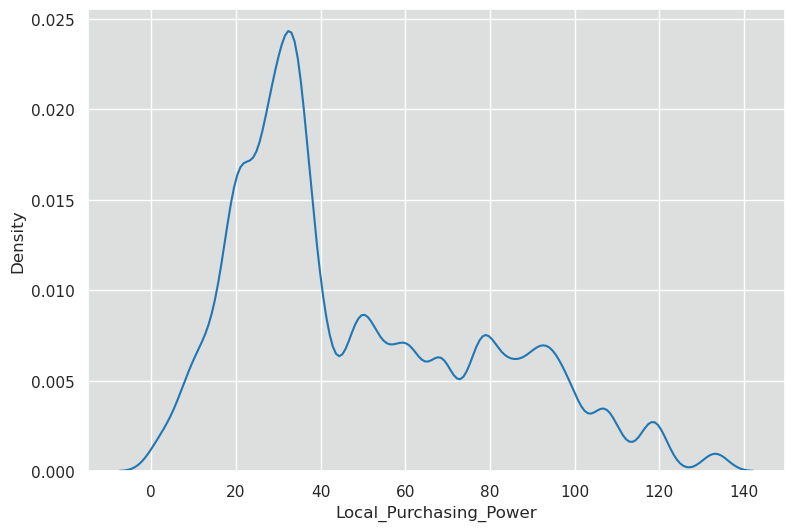

In [152]:
sns.kdeplot(
    data = out_cost,
    x = 'Local_Purchasing_Power',
    bw_method = 0.1
)

In [153]:
stats = out_cost['Local_Purchasing_Power'].describe()
stats

count    139.00000
mean      49.04964
std       29.99500
min        1.50000
25%       27.70000
50%       37.40000
75%       70.10000
max      133.20000
Name: Local_Purchasing_Power, dtype: float64

<Axes: >

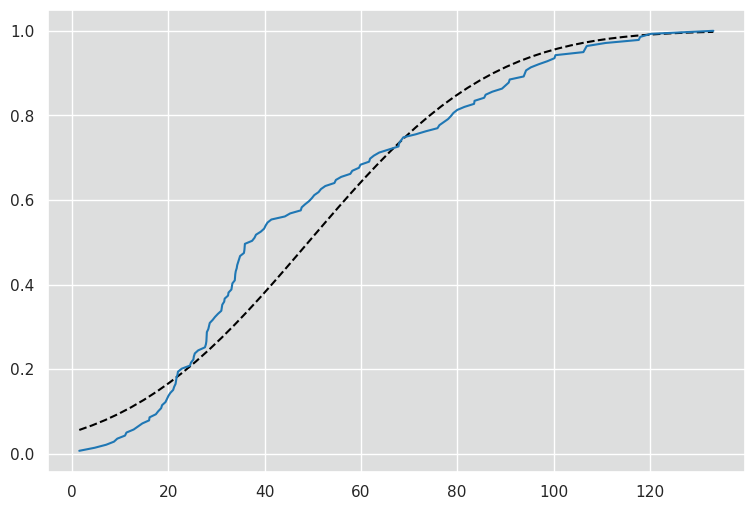

In [154]:
xs = np.linspace(stats['min'], stats['max']) #array de valores
ys = scipy.stats.norm(stats['mean'], stats['std']).cdf(xs) #valores de probabilidad

plt.plot(xs, ys, color='black', linestyle='dashed')

empiricaldist.Cdf.from_seq(
    out_cost['Local_Purchasing_Power'],
    normalize = True
).plot()

<Axes: xlabel='Local_Purchasing_Power', ylabel='Density'>

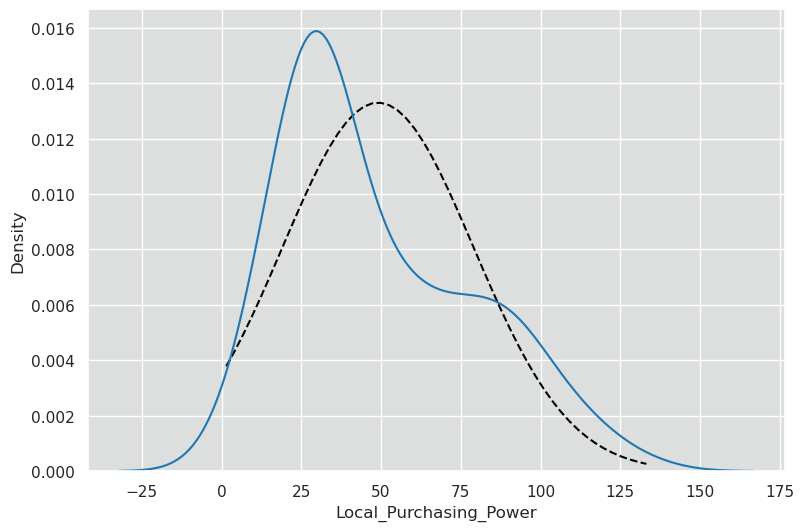

In [155]:
xs = np.linspace(stats['min'], stats['max']) #array de valores
ys = scipy.stats.norm(stats['mean'], stats['std']).pdf(xs) #valores de probabilidad

plt.plot(xs, ys, color='black', linestyle='dashed')

sns.kdeplot(
    data = out_cost,
    x = 'Local_Purchasing_Power' 
)

### Cost_of_Living

<Axes: xlabel='Cost_of_Living', ylabel='Density'>

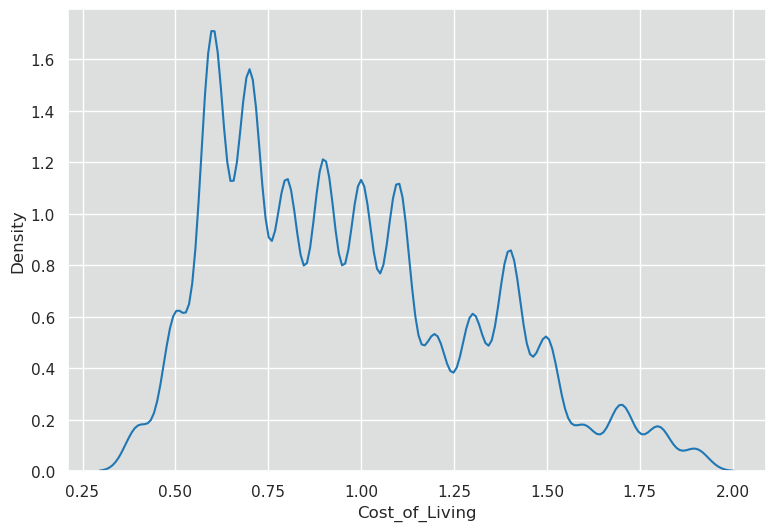

In [156]:
sns.kdeplot(
    data = out_cost,
    x = 'Cost_of_Living',
    bw_method= 0.1
)

<Axes: >

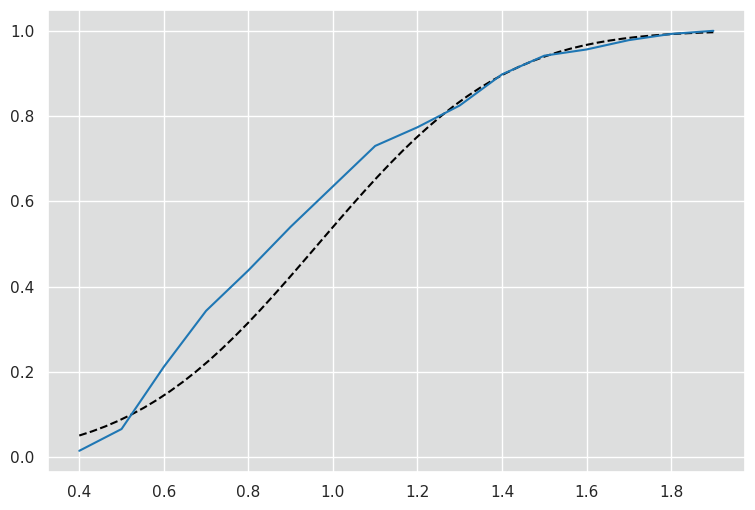

In [157]:
stats = out_cost['Cost_of_Living'].describe()

xs = np.linspace(stats['min'], stats['max']) #array de valores
ys = scipy.stats.norm(stats['mean'], stats['std']).cdf(xs) #valores de probabilidad

plt.plot(xs, ys, color='black', linestyle='dashed')

empiricaldist.Cdf.from_seq(
    out_cost['Cost_of_Living'],
    normalize = True
).plot()

<Axes: xlabel='Cost_of_Living', ylabel='Density'>

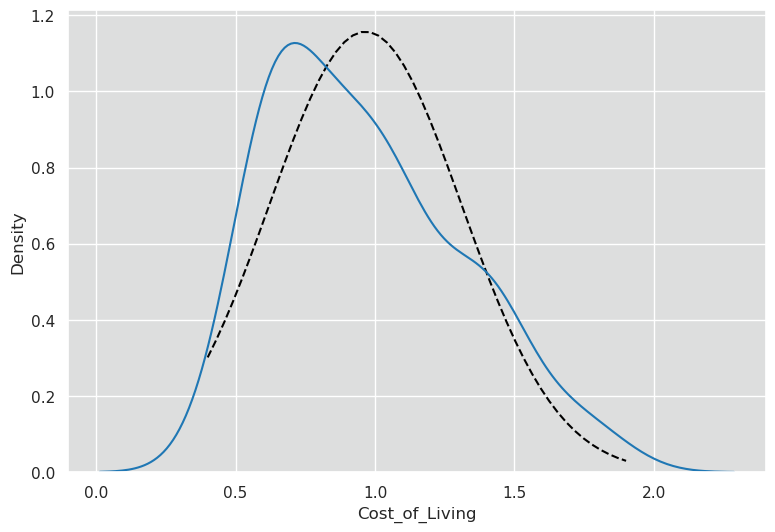

In [158]:
xs = np.linspace(stats['min'], stats['max']) #array de valores
ys = scipy.stats.norm(stats['mean'], stats['std']).pdf(xs) #valores de probabilidad

plt.plot(xs, ys, color='black', linestyle='dashed')

sns.kdeplot(
    data = out_cost,
    x = 'Cost_of_Living' 
)

In [159]:
americ = out_cost.query('Continente == "America"')
afric = out_cost.query('Continente == "Africa"')
europa = out_cost.query('Continente == "Europe"')
#oceani = out_cost.query('Continente == "Oceania"')
asi = out_cost.query('Continente == "Asia"')

continentes = [americ, afric, europa, asi]

In [160]:
cols_numeric = out_cost.select_dtypes(np.number).columns
cols_numeric 

Index(['Cost_of_Living', 'Rent', 'Cost_Plus_Rent', 'Groceries',
       'Restaurant_Price', 'Local_Purchasing_Power'],
      dtype='object')

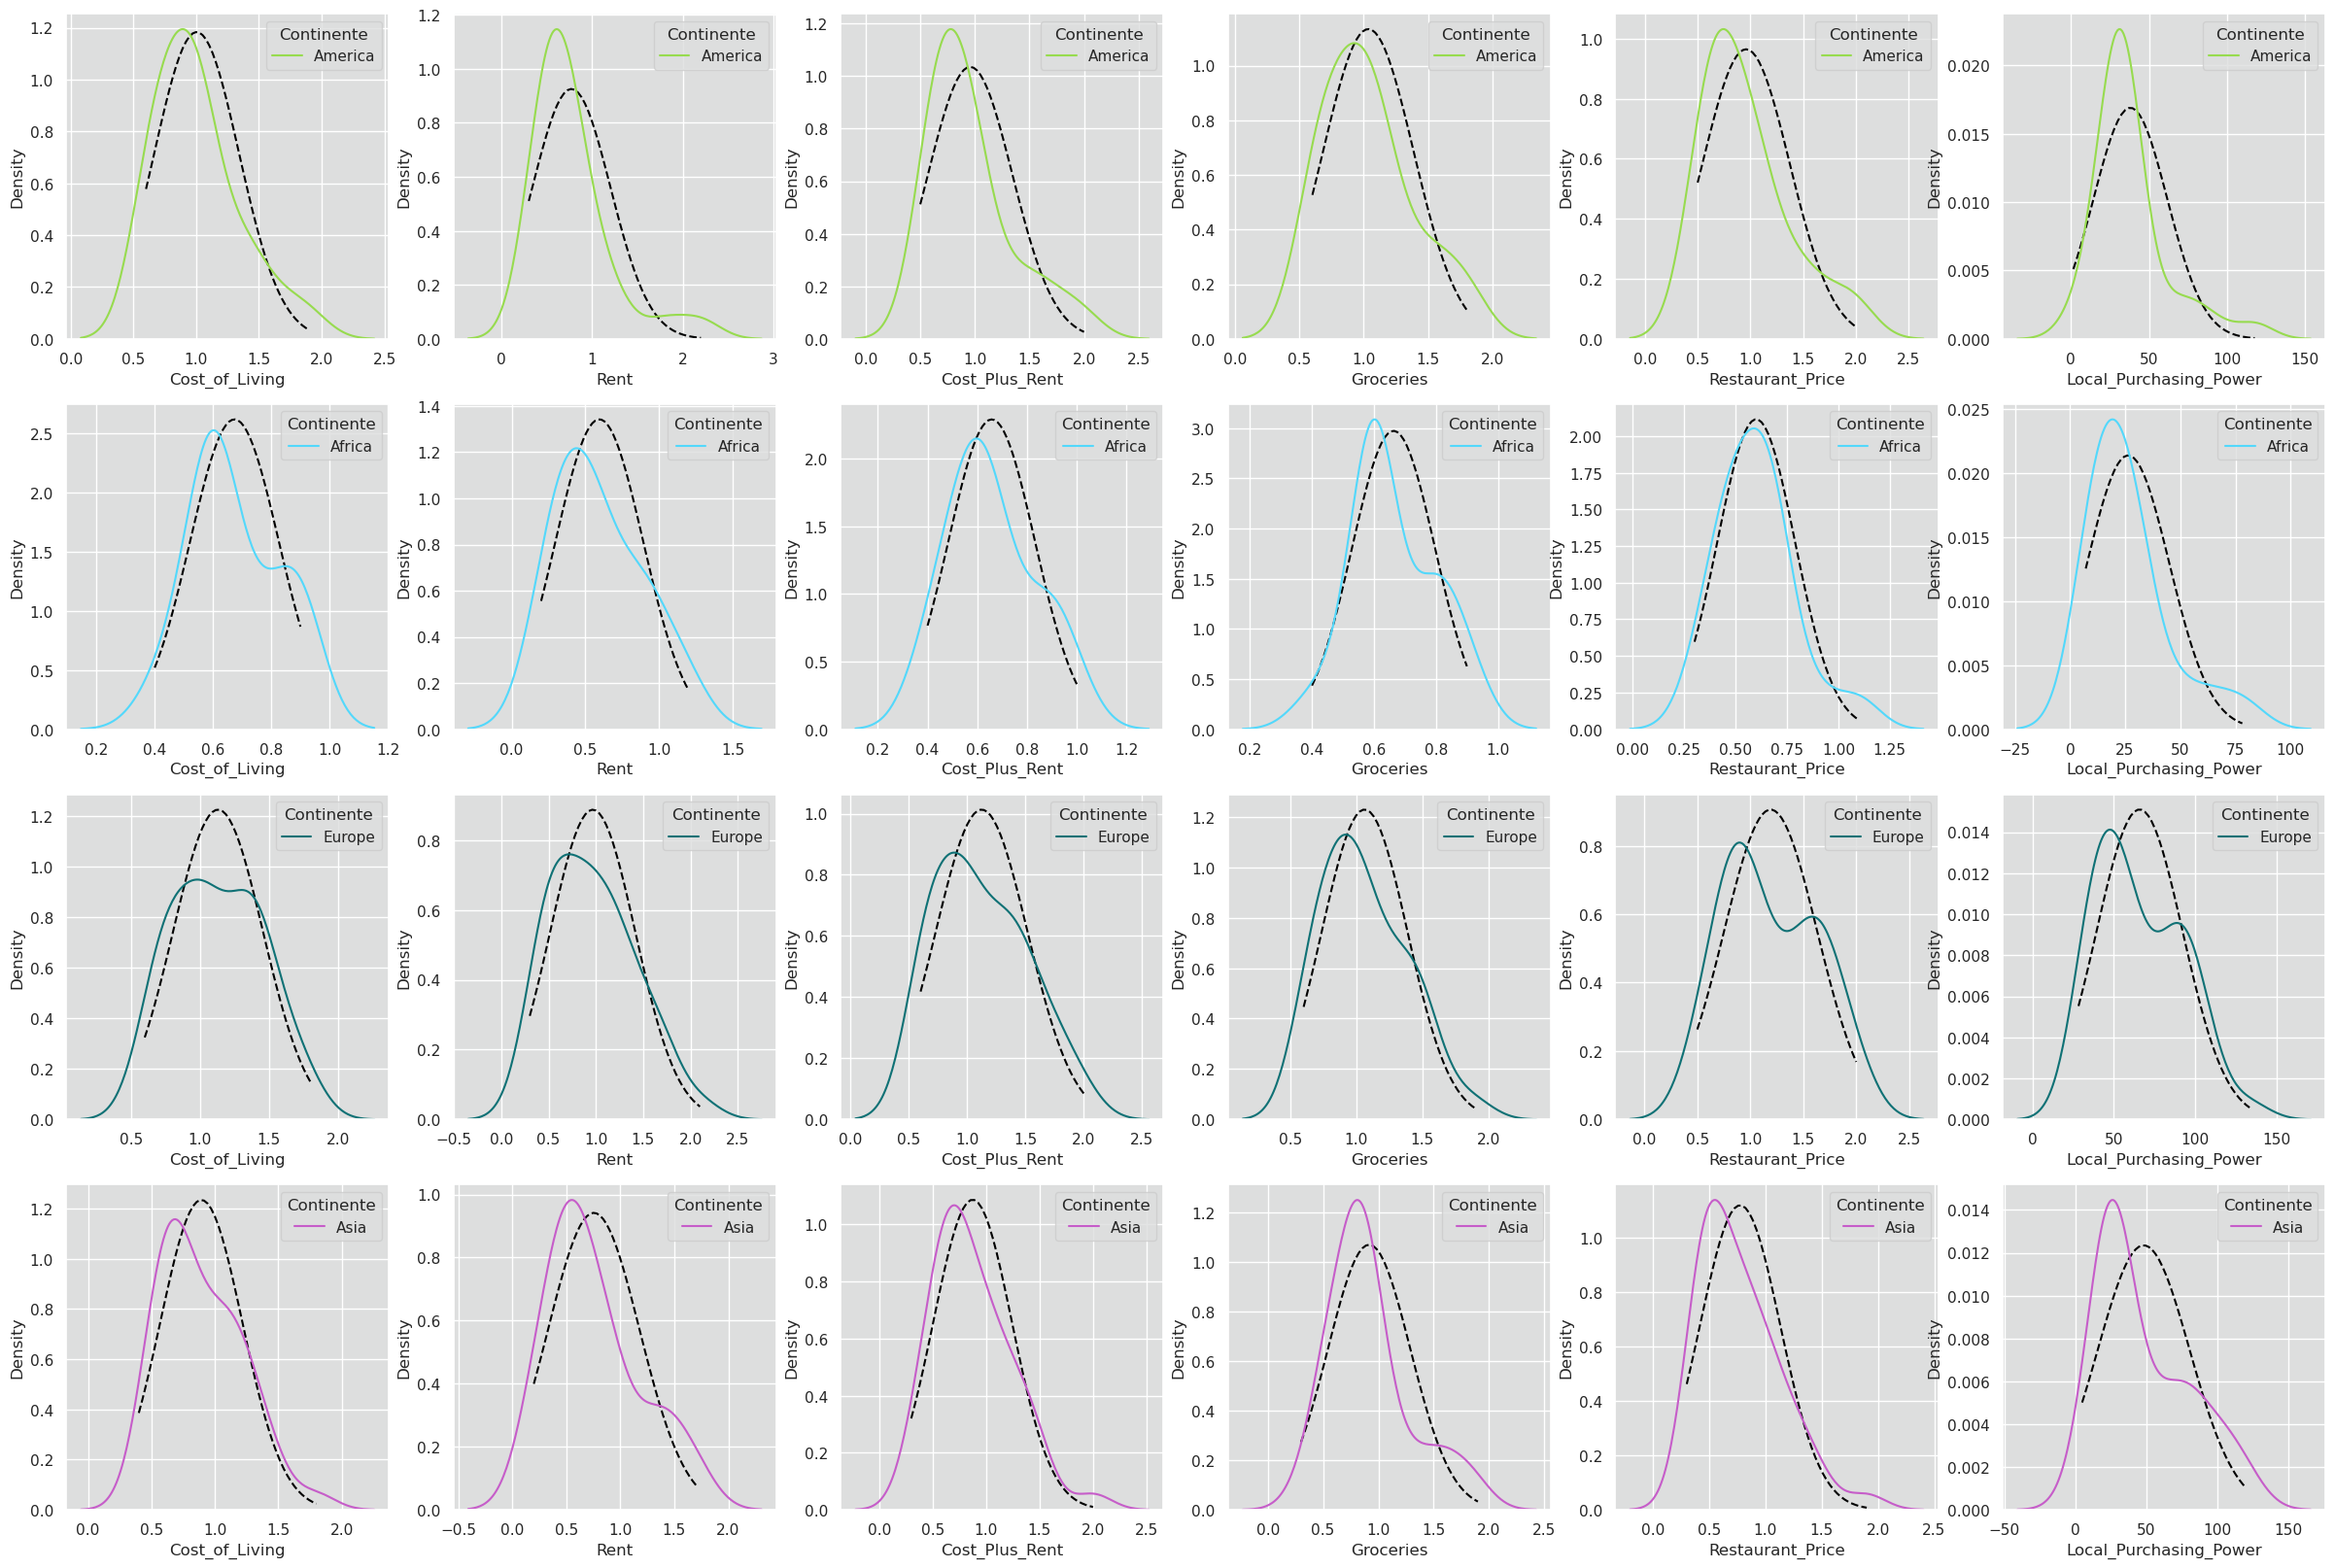

In [161]:
fig, ax = plt.subplots(4,6, figsize = (30,20))

for i, i_col in enumerate(continentes):
    for j, j_col in enumerate(cols_numeric):
        stats = i_col[j_col].describe()

        xs = np.linspace(stats['min'], stats['max'])
        ys = scipy.stats.norm(stats['mean'], stats['std']).pdf(xs)

        ax[i][j].plot(xs, ys, color = 'black', linestyle = '--')

        sns.kdeplot(
            ax = ax[i][j],
            data = i_col,
            x = j_col,
            hue = 'Continente',
            palette = continent_color
        )

In [162]:
americ = df_cost.query('Continente == "America"')
afric = df_cost.query('Continente == "Africa"')
europa = df_cost.query('Continente == "Europe"')
#oceani = df_cost.query('Continente == "Oceania"')
asi = df_cost.query('Continente == "Asia"')

continentes = [americ, afric, europa, asi]

cols_numeric = df_cost.select_dtypes(np.number).columns

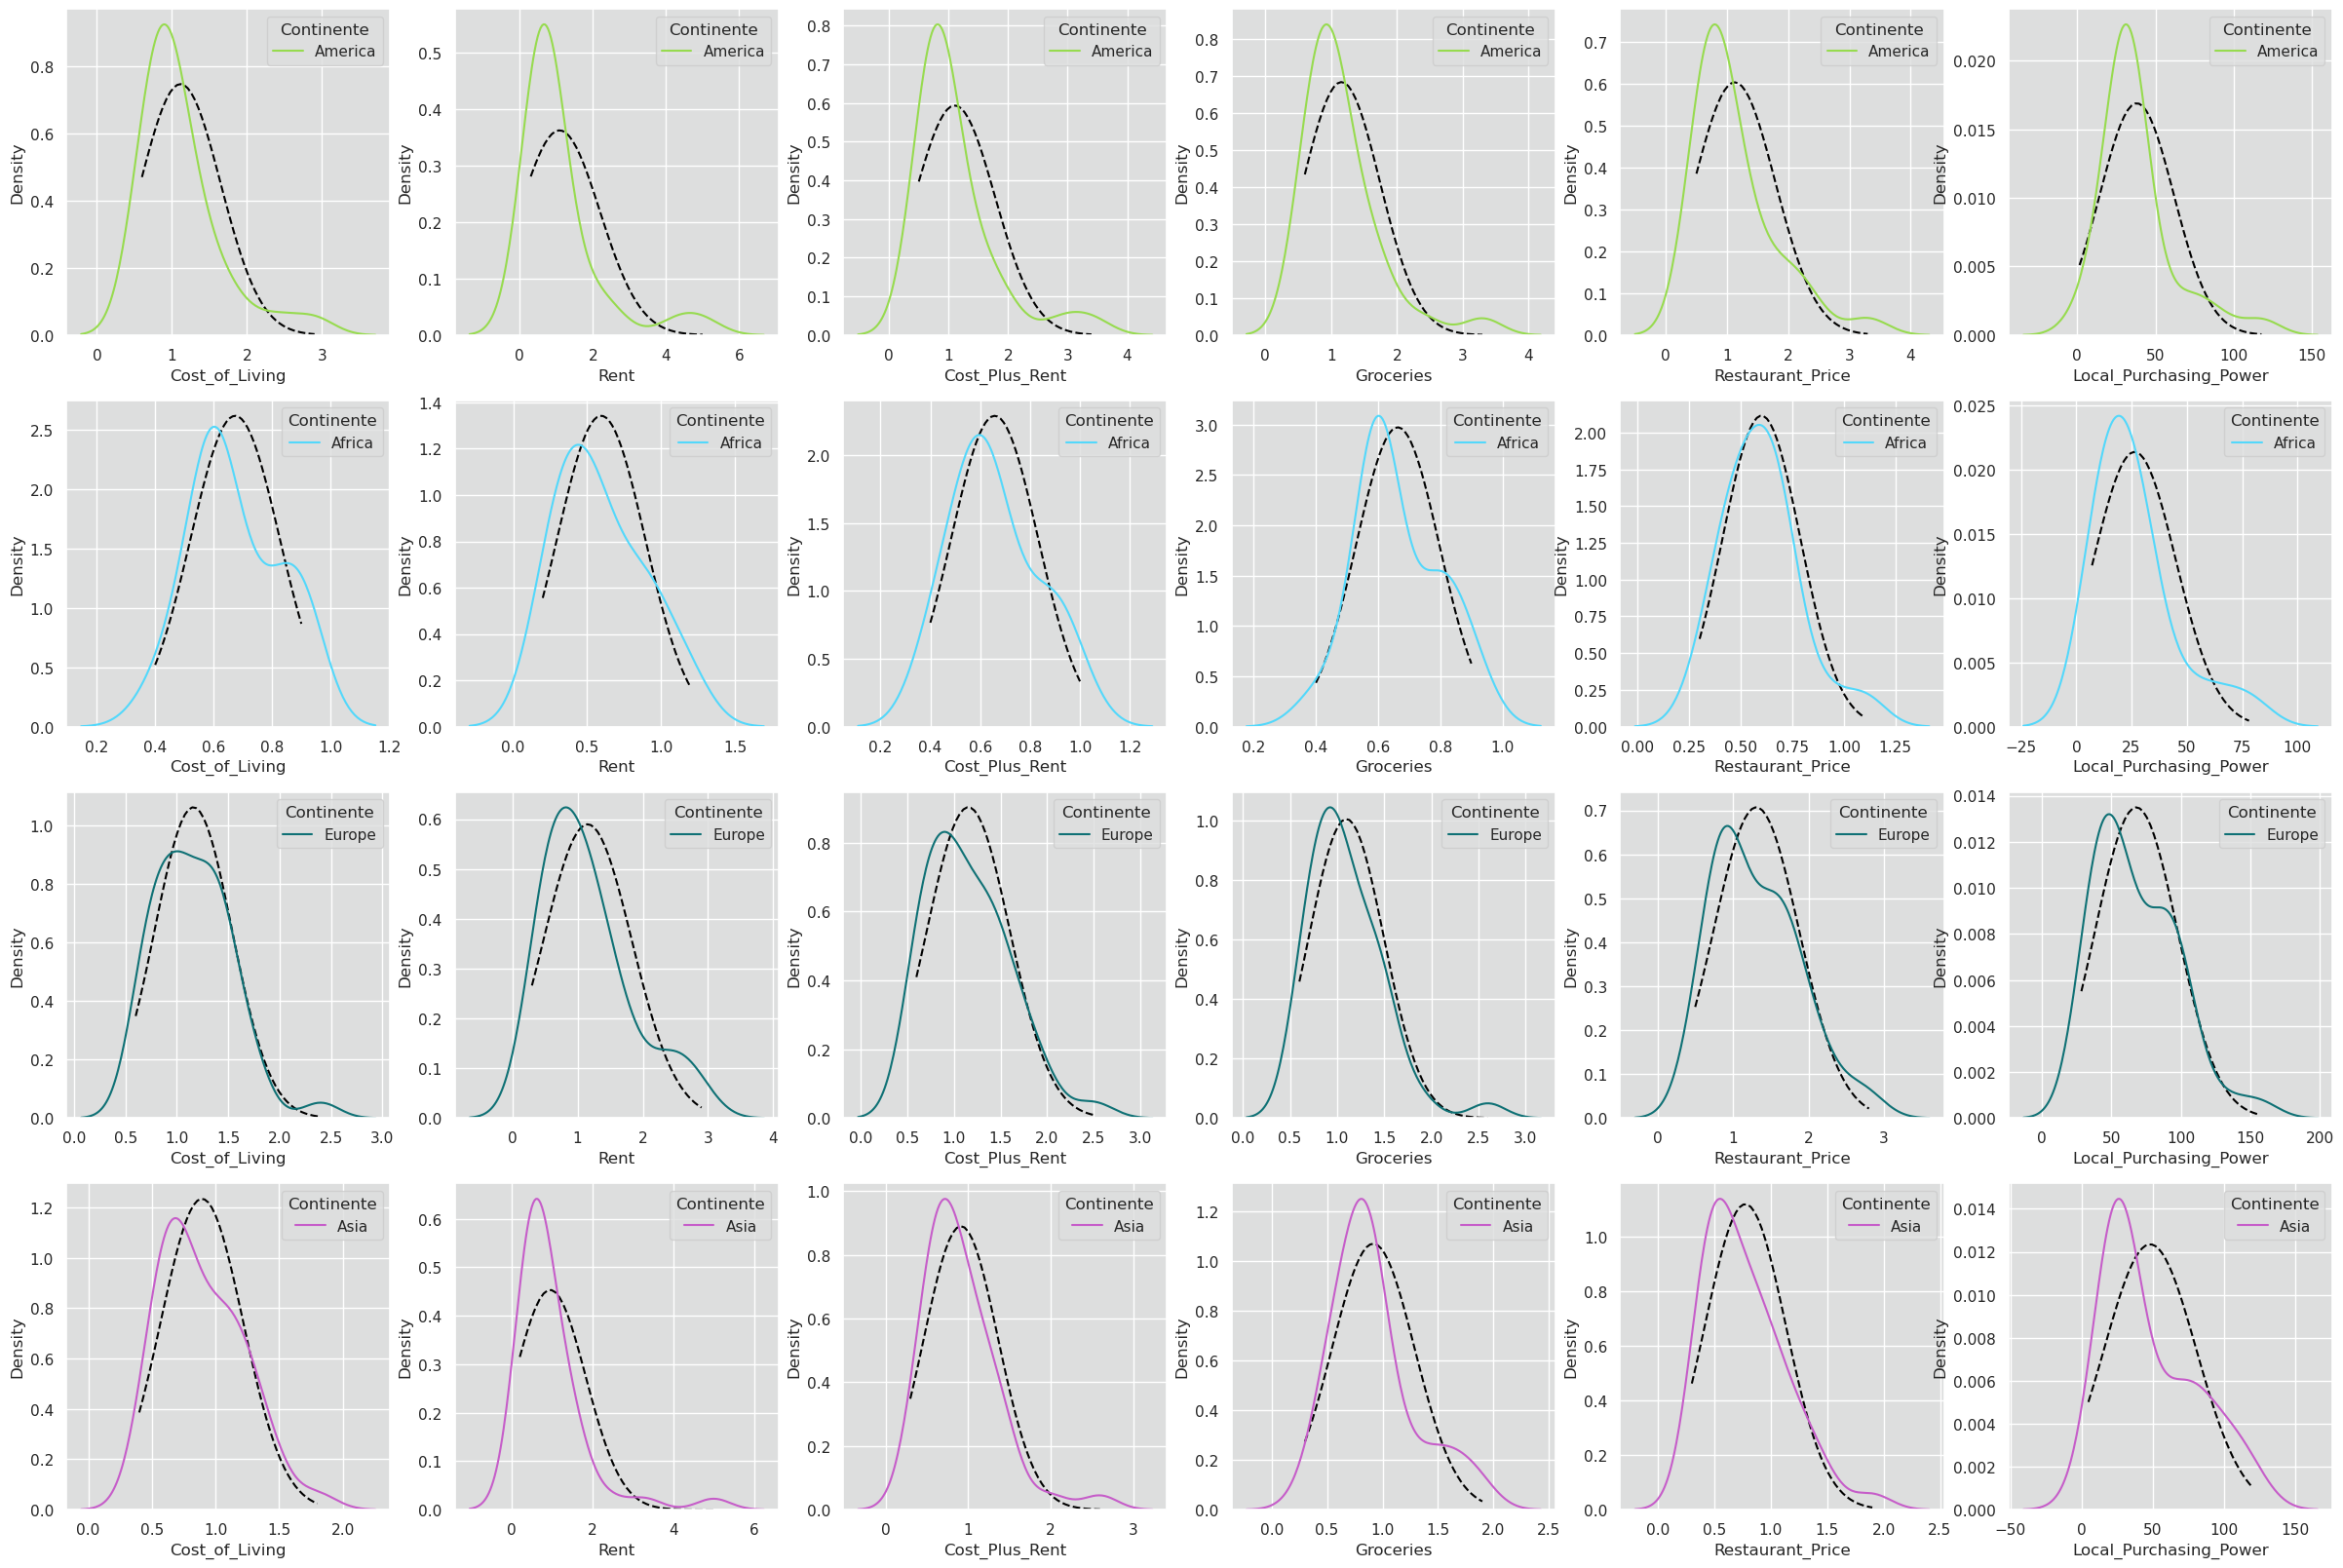

In [163]:
fig, ax = plt.subplots(4,6, figsize = (30,20))

for i, i_col in enumerate(continentes):
    for j, j_col in enumerate(cols_numeric):
        stats = i_col[j_col].describe()

        xs = np.linspace(stats['min'], stats['max'])
        ys = scipy.stats.norm(stats['mean'], stats['std']).pdf(xs)

        ax[i][j].plot(xs, ys, color = 'black', linestyle = '--')

        sns.kdeplot(
            ax = ax[i][j],
            data = i_col,
            x = j_col,
            hue = 'Continente',
            palette = continent_color
        )

In [164]:
out_cost.dropna(inplace=True)

In [165]:
sample = out_cost['Local_Purchasing_Power'].to_numpy()

model = KernelDensity(bandwidth=10, kernel = 'gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)

KernelDensity(bandwidth=10)

In [166]:
values = np.asarray([value for value in range(-100, 80)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = np.exp(probabilities)

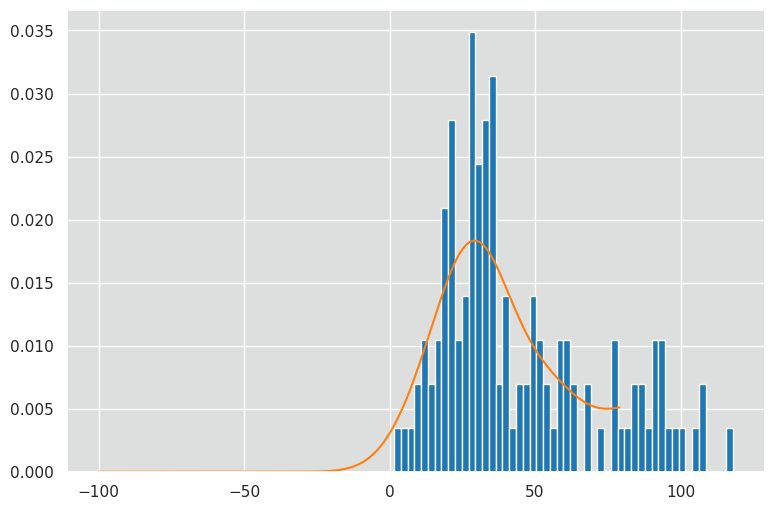

In [167]:
plt.hist(sample, bins = 50, density= True)
plt.plot(values, probabilities)
plt.show()

In [168]:
cost = out_cost['Cost_of_Living'].to_numpy()

model = KernelDensity(bandwidth=10, kernel = 'gaussian')
sample = cost.reshape((len(cost), 1))
model.fit(sample)

values_1 = np.asarray([value for value in range(-100, 80)])
values_1 = values.reshape((len(values_1), 1))
probabilities = model.score_samples(values_1)
probabilities = np.exp(probabilities)

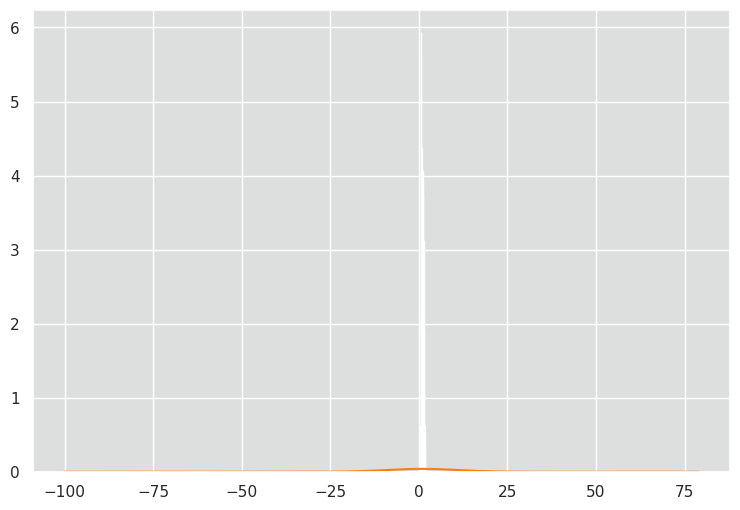

In [169]:
plt.hist(cost, bins = 50, density= True)
plt.plot(values_1, probabilities)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3aa0e2c3-1d5b-4b17-bb31-7a3c04c89158' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>